# Segundo trabajo práctico 
# Machine Learning para Macroeconomía y Finanzas

## Profesor: Josué Cox L.
## Asistente de docencia: Luis Surco

## Marcelo Gallardo 20191962 

In [210]:
# Librerias #

# Loading Libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
# Presenta las figuras debajo del script que lo crea en Jupyter Notebook
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight') # Mejora el estilo de los gráficos
import requests
from scipy import stats
from pandas_datareader import data
import scipy.signal as signal
import statsmodels.api as sm
import pmdarima as pmd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import sparse
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from scipy.stats import norm

from statsmodels.tsa.stattools import grangercausalitytests
import time

np.random.seed(2)


# pregunta 3

import types
import seaborn as sns

## Funciones

In [211]:

# Funcion que genera el test para todas las variables GRANGER 
def grangers_causation_matrix(data, variables, test=test, verbose=False):    

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# si el p value que se calcula es menor a 0.05 se rechaza H_0



# VAR MCO
def var_mco(df,p=2):
    
    # Find the size of the dataset
    T,K = df.shape

    # Auxiliary matrices
    Y_ = df.transpose()
    Z  = np.ones(T-p)

    for i_p in range(p):
        if i_p == 0:
            Y = Y_.iloc[:,p-i_p:T-i_p].values
        else:
            Y = np.vstack([Y, Y_.iloc[:,p-i_p:T-i_p].values])

    # Create matrix X
    for i_p in range(p):
        for i_k in range(K):
            Z = np.vstack([Z, Y_.iloc[i_k,p-1-i_p:-1-i_p].values])

    A_matrix    = np.dot( np.dot(Y,Z.T)   ,  np.linalg.inv(np.dot(Z,Z.T)) )
    A_intercept = A_matrix[:,0]
    A_coeff     = A_matrix[:,1::]
    
    # Covariance Matrices
    U_       = Y - np.dot(A_matrix,Z)
    Sigma_U  = np.dot(U_,U_.T)/(T-p-p*K-1)
    Sigma_ML = np.dot(U_,U_.T)/(T-p)
    
    return A_intercept, A_coeff, Sigma_U, Sigma_ML, U_, Z, K, T

# Funciones Impulso Respuesta Estructurales con Identificacion Recursive (Cholesky)
def FIR(A,Sigma,p,h,K):

    # Construir la matrix J como en las notas
    J = np.hstack([np.eye(K), np.zeros((K, K*(p-1)))])
    
    # Solo necesitamos la submatriz KxK de Sigma para la descomposicion '(B^{-1})
    Sig = Sigma[0:K,0:K]
    
    # FIR en el impacto i=0 (noten que usamos una identificacion de Cholesky - recursiva)
    B0inv = np.linalg.cholesky(Sig)
    FIR   = np.reshape(np.dot(np.dot(np.dot(J,np.linalg.matrix_power(A1,0)),J.T),B0inv).T,
                       (K*K,1))
    
    for i in range(1,h+1):
        FIR = np.hstack([FIR, 
                         np.reshape(np.dot(np.dot(np.dot(J,np.linalg.matrix_power(A,i)),J.T),B0inv).T,
                                    (K*K,1))])
    
    return FIR, B0inv

# Descomposición de la varianza del error de predicción
def MSPE(A,Sigma,K,p,h):
    # Construir la matrix J como en las notas
    J = np.hstack([np.eye(K), np.zeros((K, K*(p-1)))])

    # Solo necesitamos la submatriz KxK de Sigma para la descomposicion '(B^{-1})
    Sig = Sigma[0:K,0:K]

    # Obtenemos Psi
    Psi    = np.dot(np.dot(J,np.linalg.matrix_power(A,0)),J.T)
    Theta  = np.dot(Psi,np.linalg.cholesky(Sig)).T
    Theta2 = np.multiply(Theta,Theta)
    Theta3 = Theta2.copy()

    for i in range(1,h):
        Psi = np.dot(np.dot(J,np.linalg.matrix_power(A,i)),J.T)
        Theta  = np.dot(Psi,np.linalg.cholesky(Sig)).T
        Theta2 = np.multiply(Theta,Theta)
        Theta3 = Theta3 + Theta2.copy()
    
    Theta4 = np.sum(Theta3,axis=0)

    # Matrix for decomposition
    MSPE = np.zeros((K, K))
    for j in range(K):
        MSPE[j,:] = np.divide(Theta3[j,:],Theta4)*100
    
    return MSPE.T




In [238]:
# Funciones Impulso Respuesta Estructurales con Identificacion Recursive (Cholesky)
def FIR_bis(By, smat, nstep):
    
    # Código desarrollado por Chris Sims (https://www.princeton.edu/~sims/)
        # smat is a square matrix of initial shock vectors.  To produce "orthogonalized
        # impulse responses" it should have the property that smat'*smat=sigma, where sigma
        # is the Var(u(t)) matrix and u(t) is the residual vector.  One way to get such a smat
        # is to set smat=chol(sigma).  To get the smat corresponding to a different ordering,
        # use smat=chol(P*Sigma*P')*P, where P is a permutation matrix.
        # By is a neq x nvar x nlags matrix.  neq=nvar, of course, but the first index runs over 
        # equations. In response, the first index runs over variables, the second over 
        # shocks (in effect, equations). 
    
    neq,nvar,nlag   = np.shape(By)
    response        = np.zeros((nvar,neq,nstep))
    response[:,:,0] = smat.T
    
    for it in range(1,nstep):
        for ilag in range(min(nlag,it)):
            response[:,:,it] = response[:,:,it] + \
                                np.dot(By[:,:,ilag],response[:,:,it-ilag-1])
    
    return response

In [149]:
# Draw of a Wishart Distribution
def Wish_dist(h,n):
    i1,i2 = np.shape(h)
    A     = np.dot(np.linalg.cholesky(h),np.random.randn(i1,n))
    
    return np.dot(A,A.T)

In [164]:
def transform(column, transforms):
    transformation = transforms[column.name]
    # For quarterly data like GDP, we will compute
    # annualized percent changes
    mult = 4 if column.index.freqstr[0] == 'Q' else 1
    
    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Second difference
    elif transformation == 3:
        column = column.diff().diff()
    # 4 => Log
    elif transformation == 4:
        column = np.log(column)
    # 5 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    elif transformation == 5:
        column = np.log(column).diff() * 100 * mult
    # 6 => Log second difference, multiplied by 100
    #      with optional multiplier for annualization
    elif transformation == 6:
        column = np.log(column).diff().diff() * 100 * mult
    # 7 => Exact percent change, multiplied by 100
    #      with optional annualization
    elif transformation == 7:
        column = ((column / column.shift(1))**mult - 1.0) * 100
        
    return column


In [212]:
def remove_outliers(dta):
    # Compute the mean and interquartile range
    mean = dta.mean()
    iqr = dta.quantile([0.25, 0.75]).diff().T.iloc[:, 1]
    
    # Replace entries that are more than 10 times the IQR
    # away from the mean with NaN (denotes a missing entry)
    mask = np.abs(dta) > mean + 10 * iqr
    treated = dta.copy()
    treated[mask] = np.nan

    return treated

In [166]:
def load_fredmd_data(vintage):
    
    base_url = r'C:/Users/marce/OneDrive/Documents/PUCP/2023-0/Machine Learning para Macroeconomia y Finanzas/Trabajos/Trabajo 2'
    
    # - FRED-MD --------------------------------------------------------------
    # 1. Download data
    orig_m = (pd.read_csv(f'C:/Users/marce/OneDrive/Documents/PUCP/2023-0/Machine Learning para Macroeconomia y Finanzas/Trabajos/Trabajo 2/MD/{vintage}.csv')
                .dropna(how='all'))
    
    # 2. Extract transformation information
    transform_m = orig_m.iloc[0, 1:]
    orig_m = orig_m.iloc[1:]

    # 3. Extract the date as an index
    orig_m.index = pd.PeriodIndex(orig_m.sasdate.tolist(), freq='M')
    orig_m.drop('sasdate', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_m = orig_m.apply(transform, axis=0,
                         transforms=transform_m)

    # 5. Remove outliers (but not in 2020)
    dta_m.loc[:'2019-12'] = remove_outliers(dta_m.loc[:'2019-12'])

    # - FRED-QD --------------------------------------------------------------
    # 1. Download data
    orig_q = (pd.read_csv(f'C:/Users/marce/OneDrive/Documents/PUCP/2023-0/Machine Learning para Macroeconomia y Finanzas/Trabajos/Trabajo 2/QD/{vintage}.csv')
                .dropna(how='all'))

    # 2. Extract factors and transformation information
    factors_q = orig_q.iloc[0, 1:]
    transform_q = orig_q.iloc[1, 1:]
    orig_q = orig_q.iloc[2:]

    # 3. Extract the date as an index
    orig_q.index = pd.PeriodIndex(orig_q.sasdate.tolist(), freq='Q')
    orig_q.drop('sasdate', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_q = orig_q.apply(transform, axis=0,
                          transforms=transform_q)

    # 5. Remove outliers (but not in 2020)
    dta_q.loc[:'2019Q4'] = remove_outliers(dta_q.loc[:'2019Q4'])
    
    # - Output datasets ------------------------------------------------------
    return types.SimpleNamespace(
        orig_m=orig_m, orig_q=orig_q,
        dta_m=dta_m, transform_m=transform_m,
        dta_q=dta_q, transform_q=transform_q, factors_q=factors_q)

# Pregunta 1

En esta pregunta usaran el modelo VAR propuesto por Castillo, Montoya y Quineche (2016) donde se estudia la moderación en la volatilidad de algunos agregados macroeconómicos. Estos autores usan un modelo VAR estructural con parámetros y matriz de varianza-covarianza que cambian en el tiempo. En esta pregunta, usarán un VAR estructural más simple con parámetros y matriz de varianza-covarianza constantes en el tiempo y una descomposición recursiva para identificar el VAR. Deberán usar las tres variables analizadas en el paper, el mismo tamaño de la muestra y la misma orden de las variables (importante para la estimación del VAR estructural). Obtengan los datos del BCRP usando el API de tal forma que los datos puedan ser importados directamente a Python. Responder las siguientes preguntas

1. Hacer un gráfico con las variables a incluir en el VAR.
2. Realice el test de causalidad de Granger tomando como máximo 12 rezagos de la variable.
3. Calcule el número de rezagos óptimo usando los criterios de información. Mencione cuál criterio escoge (y la razón) si es        que los criterios dan resultados diferentes.
4. Estime el VAR en forma reducida presentando el vector de intercepto, las matrices de rezagos, la matriz de covarianza, y        grafique shocks de la forma reducida.
5. Genere una proyección de dos años a partir del final de la muestra (2014:Q3). Construya los intervalos de confianza para        su proyección.
6. Estime y grafique las funciones de impulso respuesta estructurales de un shock de demanda, un shock de oferta y un shock        de política monetaria para un horizonte máximo de 8 trimestres. Construya la tabla para el MSPE considerando $h=1,2,3,12, \infty$. 
7. Construya la descomposición histórica para la tasa de crecimiento del PBI.
8. Genere dos escenarios de predicción para el periodo de proyección en el punto 5. En particular, use las sendas históricas        del shock de politica en dos periodos del tiempo 2006:Q1 – 2007:Q2 y 2008:Q1 – 2009:Q4.


En el paper From the “Great Inflation” to the “Great Moderation” in Peru: A Time Varying Structural 
Vector Autoregressions Analysis, de Castillo, Montoya y Quineche, se usa el siguiente modelo

$$ y_t \in \mathbb{R}^{3}, \ y_t =A_{0, t} + \sum_{j=1}^{p}A_{j, t}y_{t-j} + u_t$$

donde $p =2$ y $y_t =(\text{crecimiento del PBI real}_t, \text{tasa de inflación}_t, \text{tasa de crecimiento del dinero}_t)^{'}$. El periodo usado en el paper es: 1981:I-2014:III.

## Recuperando la data 

Observación: la data no está en el formato del paper. Hay que considerar el periodo reducido $[1993-T1, 2014-3]$. Luego, la inflación y el dinero no está en frecuencia trimestral por lo que, se va a transformar para que coincidan con la data trimestral. Finalmente, lo que nos interesa es 

$$ x_t \to \frac{x_{t+1}-x_t}{x_t} \cdot 100.$$

Por ende, usamos las variables indicadas en la sesión de práctica. Si bien en el paper usan: tasa de crecimiento del PBI, el dinero y de la inflación, usaremos "proxys" disponibles en el BCRP.

In [440]:
#  PBI PN02516AQ indice 2007: =100
# pbi VAR %  PN02507AQ
#  PN03492MQ circulante 
#  inflacion: PN01271PM

In [255]:
# exportar series de tiempo

url_base  = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/api/'
cod_var   = ['PN37692AQ'] 
form_out  = '/json'
period    = '/1992-T1/2014-T3'


df_trimestral = pd.DataFrame()

for j in cod_var:
    url_aux   = url_base + j + form_out + period
    resp      = requests.get(url_aux)
    resp_json = resp.json()
    periods   = resp_json['periods']
    
    value = []
    dates = []
    
    for i in periods:
        aux_dat = i['name']
        aux_val = i['values']
        dates.append(aux_dat)
        value.append(float(aux_val[0]))
    
    dict_aux = {'Fecha' : dates, 
                 resp_json['config']['series'][0]['name'] : value}
    df_aux = pd.DataFrame(dict_aux)
    df_aux.set_index(df_aux['Fecha'], inplace=True)
    df_aux = df_aux.drop(columns=['Fecha'])
    df_trimestral    = pd.concat([df_trimestral, df_aux], axis=1)

    
df_trimestral=np.log(df_trimestral).diff()




In [256]:
df_trimestral.fillna('bfill')
display(df_trimestral)

Producto bruto interno (millones de soles constantes de 2007) - PBI Global
Fecha                                                                            
T1.93                                                NaN                         
T2.93                                           0.079632                         
T3.93                                          -0.023392                         
T4.93                                           0.015133                         
T1.94                                           0.048894                         
...                                                  ...                         
T4.13                                           0.046482                         
T1.14                                          -0.086398                         
T2.14                                           0.053540                         
T3.14                                           0.004445                         
T4.14                                           0.039034                         

[88 rows x 1 columns]

In [257]:
df_trimestral = df_trimestral.rename(columns={'Producto bruto interno (millones de soles constantes de 2007) - PBI Global': 'PBI growth rate'})
display(df_trimestral)

PBI growth rate
Fecha                 
T1.93              NaN
T2.93         0.079632
T3.93        -0.023392
T4.93         0.015133
T1.94         0.048894
...                ...
T4.13         0.046482
T1.14        -0.086398
T2.14         0.053540
T3.14         0.004445
T4.14         0.039034

[88 rows x 1 columns]

In [258]:
df_trimestral = df_trimestral.drop(df_trimestral.index[-1])

In [259]:
df_trimestral['PBI growth rate'] *= 100

In [260]:
df_trimestral.to_csv('trimestal.csv')

In [261]:
df=pd.read_csv("trimestal.csv")
df.drop(columns=["Fecha"], inplace=True)
df.fillna(method='bfill', inplace=True)
display(df)

PBI growth rate
0          7.963215
1          7.963215
2         -2.339225
3          1.513254
4          4.889352
..              ...
82         0.578179
83         4.648166
84        -8.639825
85         5.353968
86         0.444469

[87 rows x 1 columns]

In [262]:
# importo dinero e inflacion mensual   PN38705PM
url_base  = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/api/'
cod_var   = ['PN00233MM','PN01273PM'] 
form_out  = '/json'
period    = '/1993-1/2014-7'

month_s = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Set','Oct','Nov','Dic']
month_d = ['01','02','03','04','05','06','07','08','09','10','11','12']


df_mensual = pd.DataFrame()

for j in cod_var:
    url_aux   = url_base + j + form_out + period
    resp      = requests.get(url_aux)
    resp_json = resp.json()
    periods   = resp_json['periods']
    
    value = []
    dates = []
    
    for i in periods:
        aux_dat = i['name']
        aux_val = i['values']
        dates.append(aux_dat)
        value.append(float(aux_val[0]))
    
    dict_aux = {'Fecha' : dates, 
                 resp_json['config']['series'][0]['name'] : value}
    df_aux = pd.DataFrame(dict_aux)

    df_aux['Fecha'] = df_aux['Fecha'].str.replace('.','-')
    for (s,d) in zip(month_s,month_d):
        df_aux['Fecha'] = df_aux['Fecha'].str.replace(s,d)
    df_aux['Fecha'] = pd.to_datetime(df_aux['Fecha'])

    
    df_aux.set_index(df_aux['Fecha'], inplace=True)
    df_aux = df_aux.drop(columns=['Fecha'])
    df_mensual   = pd.concat([df_mensual, df_aux], axis=1)

display(df_mensual)


Liquidez del sistema bancario - fin de periodo (var% 12 meses) - Dinero  \
Fecha                                                                                 
1993-01-01                                          74.516404                         
1993-02-01                                          76.176300                         
1993-03-01                                          72.265519                         
1993-04-01                                          60.094754                         
1993-05-01                                          50.383403                         
...                                                       ...                         
2014-03-01                                           5.411626                         
2014-04-01                                           3.482661                         
2014-05-01                                           3.728369                         
2014-06-01                                           3.898530                         
2014-07-01                                           2.975667                         

            Índice de precios Lima Metropolitana (var% 12 meses) - IPC  
Fecha                                                                   
1993-01-01                                          58.710673           
1993-02-01                                          55.973408           
1993-03-01                                          51.317476           
1993-04-01                                          53.156865           
1993-05-01                                          52.557107           
...                                                       ...           
2014-03-01                                           3.377928           
2014-04-01                                           3.523155           
2014-05-01                                           3.555644           
2014-06-01                                           3.449653           
2014-07-01                                           3.331164           

[259 rows x 2 columns]

In [221]:
df_mensual.index = pd.to_datetime(df_mensual.index)
df_quarterly = df_mensual.resample('Q').mean()



In [147]:
#df_quarterly['Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC)'] =df_quarterly['Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC)'].pct_change()


In [263]:
df_quarterly = df_quarterly.rename(columns={'Índice de precios Lima Metropolitana (var% 12 meses) - IPC': 'Inflation growth rate'})
df_quarterly = df_quarterly.rename(columns={'Liquidez del sistema bancario - fin de periodo (var% 12 meses) - Dinero': 'Money growth rate'})




In [223]:
display(df_quarterly)

Money growth rate  Inflation growth rate
Fecha                                               
1993-03-31          74.319407              55.333852
1993-06-30          55.271516              51.888179
1993-09-30          48.103168              48.117084
1993-12-31          48.201038              41.589685
1994-03-31          45.294636              33.680984
...                       ...                    ...
2013-09-30          13.196235               3.116177
2013-12-31           8.139333               2.951101
2014-03-31           4.731967               3.407952
2014-06-30           3.703187               3.509484
2014-09-30           2.975667               3.331164

[87 rows x 2 columns]

In [149]:
#df_quarterly['Inflation growth rate'].fillna(method='bfill', inplace=True)

In [264]:
df_quarterly.to_csv('df_quarterly.csv')
df1=pd.read_csv("df_quarterly.csv")
df1.drop(columns=["Fecha"], inplace=True)
display(df1)

Money growth rate  Inflation growth rate
0           74.319407              55.333852
1           55.271516              51.888179
2           48.103168              48.117084
3           48.201038              41.589685
4           45.294636              33.680984
..                ...                    ...
82          13.196235               3.116177
83           8.139333               2.951101
84           4.731967               3.407952
85           3.703187               3.509484
86           2.975667               3.331164

[87 rows x 2 columns]

In [272]:
df_combined = pd.concat([df, df1], axis=1)
display(df_combined)

PBI growth rate  Money growth rate  Inflation growth rate
0          7.963215          74.319407              55.333852
1          7.963215          55.271516              51.888179
2         -2.339225          48.103168              48.117084
3          1.513254          48.201038              41.589685
4          4.889352          45.294636              33.680984
..              ...                ...                    ...
82         0.578179          13.196235               3.116177
83         4.648166           8.139333               2.951101
84        -8.639825           4.731967               3.407952
85         5.353968           3.703187               3.509484
86         0.444469           2.975667               3.331164

[87 rows x 3 columns]

In [273]:
df_combined.ffill(axis=None, inplace=False, limit=None, downcast=None)

PBI growth rate  Money growth rate  Inflation growth rate
0          7.963215          74.319407              55.333852
1          7.963215          55.271516              51.888179
2         -2.339225          48.103168              48.117084
3          1.513254          48.201038              41.589685
4          4.889352          45.294636              33.680984
..              ...                ...                    ...
82         0.578179          13.196235               3.116177
83         4.648166           8.139333               2.951101
84        -8.639825           4.731967               3.407952
85         5.353968           3.703187               3.509484
86         0.444469           2.975667               3.331164

[87 rows x 3 columns]

In [274]:
df_combined.to_csv('data.csv', index=False)

In [275]:
data=pd.read_csv('data.csv')
display(data)

PBI growth rate  Money growth rate  Inflation growth rate
0          7.963215          74.319407              55.333852
1          7.963215          55.271516              51.888179
2         -2.339225          48.103168              48.117084
3          1.513254          48.201038              41.589685
4          4.889352          45.294636              33.680984
..              ...                ...                    ...
82         0.578179          13.196235               3.116177
83         4.648166           8.139333               2.951101
84        -8.639825           4.731967               3.407952
85         5.353968           3.703187               3.509484
86         0.444469           2.975667               3.331164

[87 rows x 3 columns]

In [268]:
#fin de periodo
dates = pd.date_range(start='1993-03-31', end='2014-09-30', freq='3M')
data.index =  pd.Series(dates)
display(data)

PBI growth rate  Money growth rate  Inflation growth rate
1993-03-31         7.963215          74.319407              55.333852
1993-06-30         7.963215          55.271516              51.888179
1993-09-30        -2.339225          48.103168              48.117084
1993-12-31         1.513254          48.201038              41.589685
1994-03-31         4.889352          45.294636              33.680984
...                     ...                ...                    ...
2013-09-30         0.578179          13.196235               3.116177
2013-12-31         4.648166           8.139333               2.951101
2014-03-31        -8.639825           4.731967               3.407952
2014-06-30         5.353968           3.703187               3.509484
2014-09-30         0.444469           2.975667               3.331164

[87 rows x 3 columns]

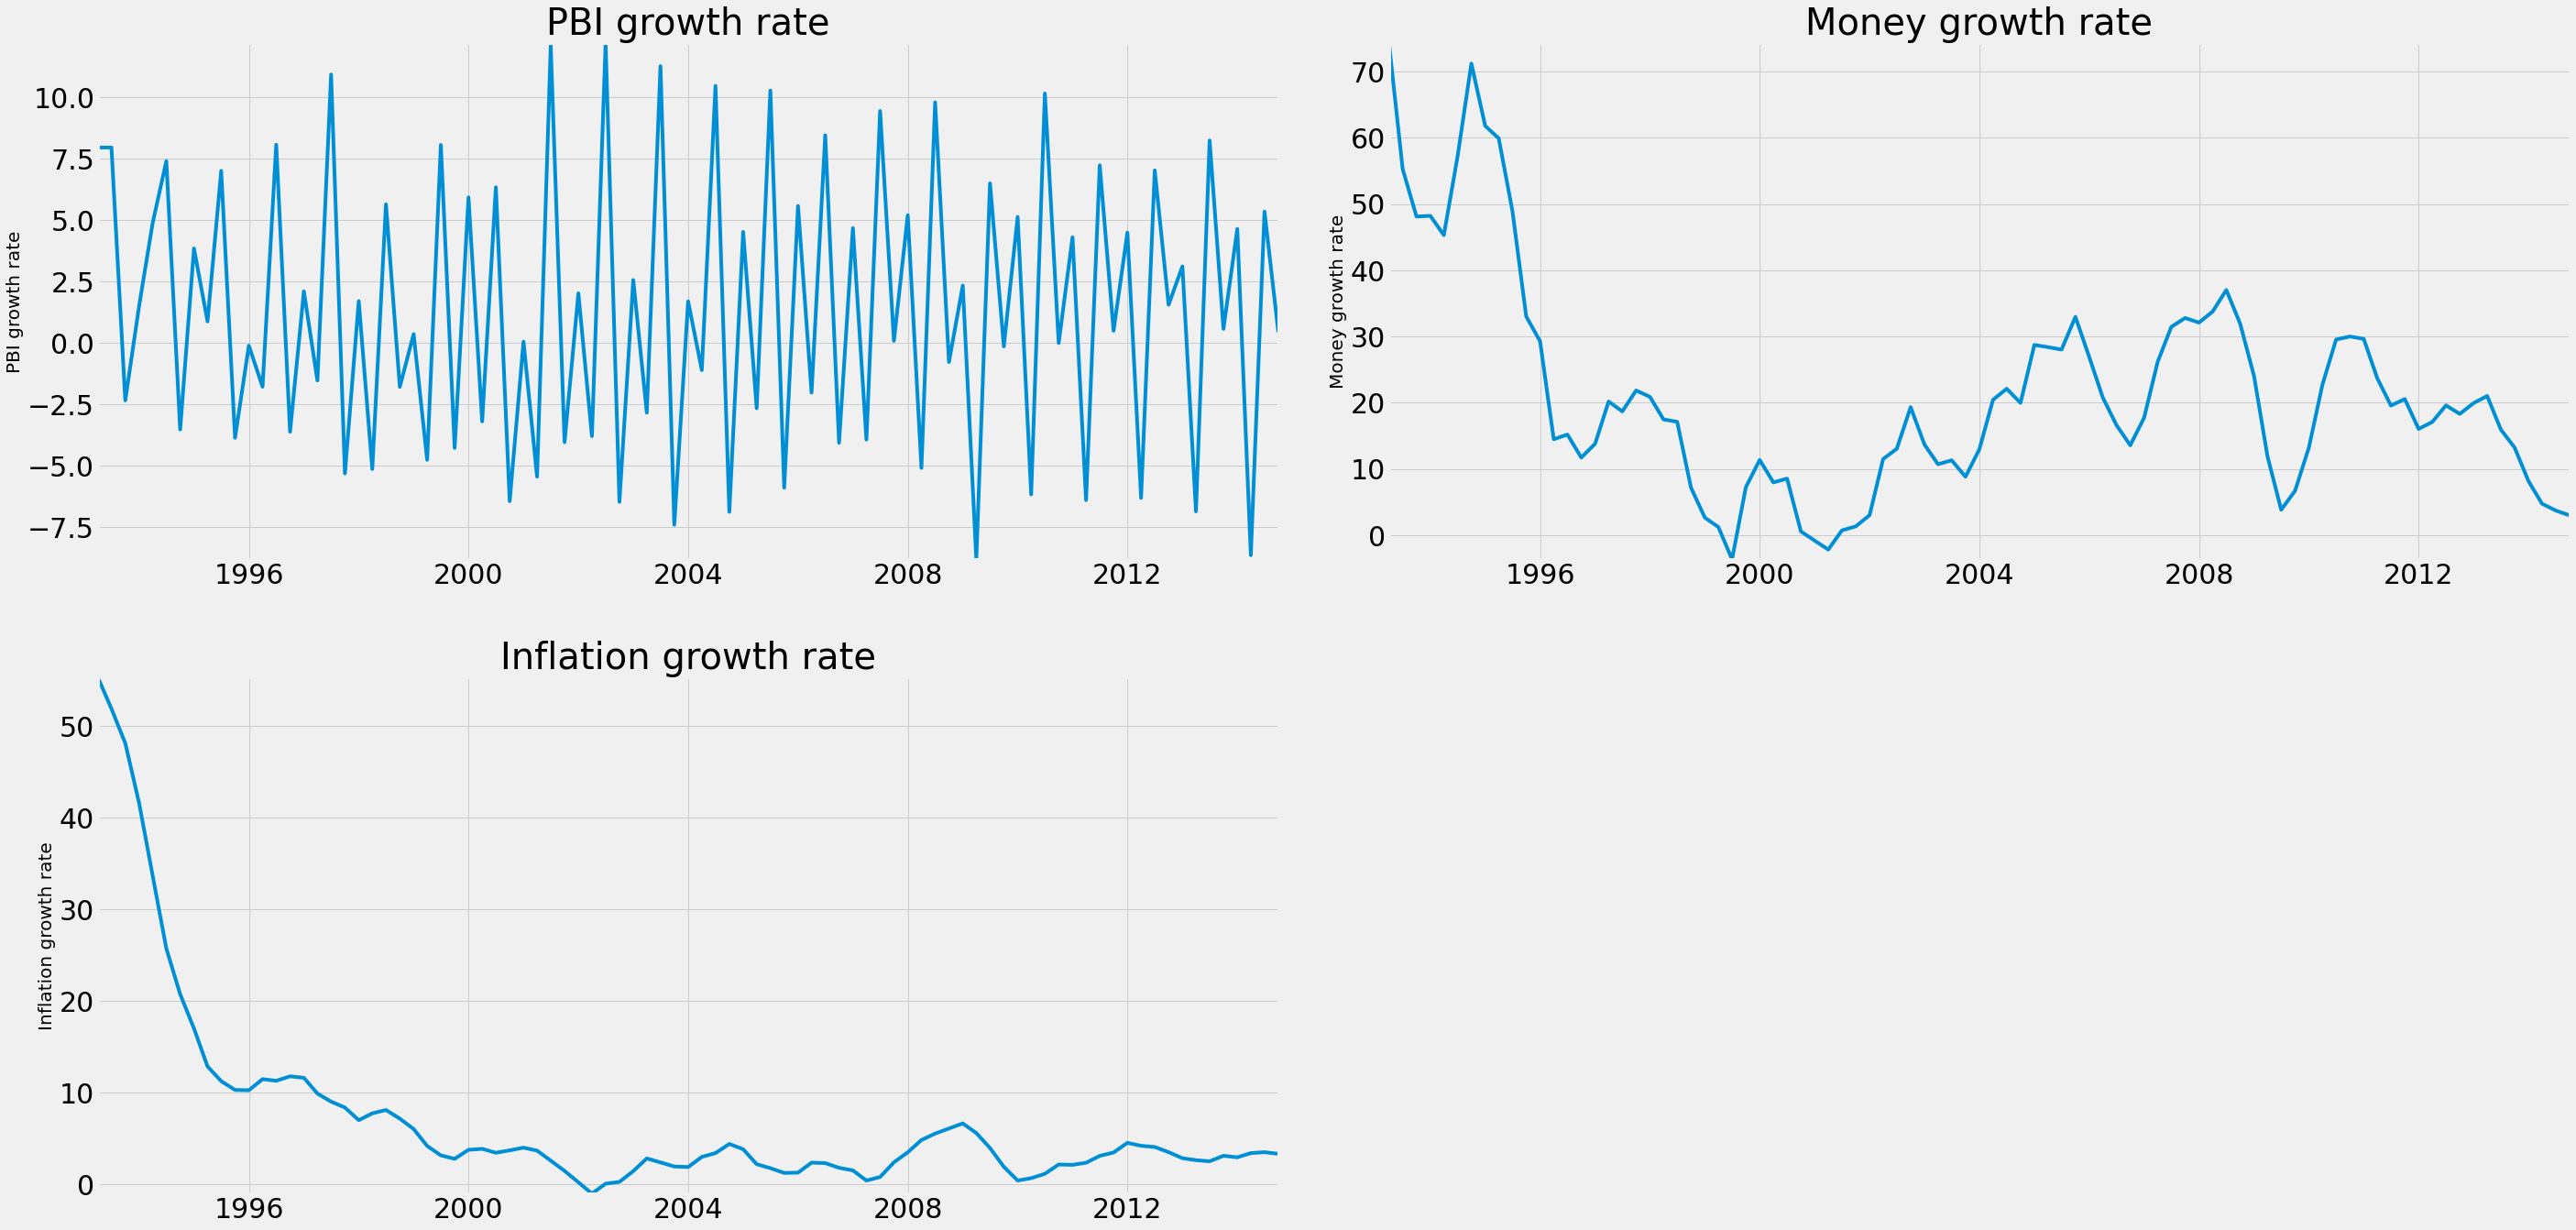

In [269]:
# Ploteo
fig = plt.figure(figsize=(40, 20))

ax1 = plt.subplot(2,2,1, frameon=True) 
ax1.plot(data['PBI growth rate'])
ax1.set_title('PBI growth rate', fontsize=40)
ax1.set_ylabel('PBI growth rate', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='both', tight=True)

ax1 = plt.subplot(2,2,2, frameon=True) 
ax1.plot(data['Money growth rate'])
ax1.set_title('Money growth rate', fontsize=40)
ax1.set_ylabel('Money growth rate', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='both', tight=True)

ax1 = plt.subplot(2,2,3, frameon=True) 
ax1.plot(data['Inflation growth rate'])
ax1.set_title('Inflation growth rate', fontsize=40)
ax1.set_ylabel('Inflation growth rate', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='both', tight=True)

fig.tight_layout(pad=4.0)



## Causalidad de Granger

Sea $\Omega_t$ el conjunto de información que contiene toda la información relevante para predecir la variable $y_1$ hasta el periodo $t$. Sea la predicción óptimo $h-$pasos adelante de $y_{1t}$ basada en la información $\Omega$, $y_{1, t+h|\Omega_t}$ y su MSPE $\sigma_{y_1}^2(h|\Omega_t)$. Entonces, decimos que el proceso $y_{2t}$ causa a lo Granger $y_{1t}$ si
\begin{equation*}
  \sigma^2_{y_1}(h|\Omega_t) < \sigma_{y_1}^2(h|\Omega_t-\{y_{2s}|s\leq t\}), \ h \in \{1, 2, ...\}
\end{equation*}


El test de causalidad que se implementa es el siguiente, $\mathbb{H}_0: $ los valores pasados de una serie temporal no contribuyen significativamente a la predicción de otra serie temporal. El estadístio que se usa es el SSR (el del modelo que incluye los rezagos pasados de la serie de tiempo).

In [231]:
# Numero maximo de lags a incluir 12
maxlag=12

# Tipo de estadistico a considerar
test = 'ssr_chi2test'

# Nombre de las variables
variables = ['PBI growth rate','Money growth rate','Inflation rate']


In [232]:
grangers_causation_matrix(data, variables =data.columns) 

PBI growth rate_x  Money growth rate_x  \
PBI growth rate_y                   1.0000               0.0000   
Money growth rate_y                 0.0083               1.0000   
Inflation growth rate_y             0.0344               0.0097   

                         Inflation growth rate_x  
PBI growth rate_y                         0.0013  
Money growth rate_y                       0.0003  
Inflation growth rate_y                   1.0000

Se concluye que las variables 2 a 2 explican  pues los p values son menores a 0.05. 

## Test de criterio de la información

Un test de criterio de la información para la elección del orden $p$ del VAR tiene la siguiente forma general
\begin{equation*}
  C(m) = \ln(\text{det} (\tilde{\Sigma}_u(m))) + c_T\varphi(m),
\end{equation*}
donde

$\tilde{\Sigma}_u(m) = \frac{1}{T}\sum_{t=1}^{T}\hat{u}_t\hat{u}_t^T$

$\varphi$ corresponde al número total de regresoras en el VAR. Por ejemplo, para $K$ series y con intercepto, 

$\varphi(m)=mK^2+K$.
 
$c_T$ es una constante que es función de $T$.


Luego, tenemos 3 criterios fundamentalmente,

- $\textbf{Criterio de información de Akaike (AIC).}$ Se toma $c_T=\frac{2}{T}$.

- $\textbf{Criterio de información de Hannan-Quinn (HQC).}$ Se toma $c_T=\frac{2\ln(\ln T)}{T}$.

- $\textbf{Criterio de información de Schwarz (SIC o BIC).}$ Se toma $c_T=\frac{\ln T}{T}$.

In [233]:
# Evaluamos los criterios de informacion para diversos valores de rezagos, en este caso, p=12. 
#El siguiente codigo esta aumatizado

p_max    = 12
model    = VAR(data)
inf_crit = pd.DataFrame()

for i in range(0,p_max+1):
    result = model.fit(i)
    tempdf = pd.DataFrame({"Lag number": [i], "AIC": [result.aic], "HQIC": [result.hqic], "BIC": [result.bic]})
    inf_crit = pd.concat([inf_crit,tempdf])
        

inf_crit.set_index('Lag number',inplace=True)
inf_crit


AIC       HQIC        BIC
Lag number                                 
0           13.255361  13.289601  13.340393
1            6.570869   6.708696   6.913336
2            5.724635   5.967371   6.328114
3            4.322494   4.671482   5.190642
4            3.995898   4.452506   5.132462
5            3.617798   4.183414   5.026609
6            3.539063   4.215100   5.224046
7            3.560508   4.348402   5.525680
8            3.577988   4.479197   5.827464
9            3.269458   4.285464   5.807452
10           3.294873   4.427180   6.125703
11           3.240696   4.490832   6.368785
12           2.789591   4.159106   6.219474

In [234]:
min_val, min_index = inf_crit.min(), inf_crit.idxmin()
print("min value:", min_val)
print("min index:", min_index)

min value: AIC     2.789591
HQIC    4.159106
BIC     5.026609
dtype: float64
min index: AIC     12
HQIC    12
BIC      5
dtype: int64


Dado que $T$ suele ser mayor (lo es) a $\lfloor e^{2}+1 \rfloor$, por lo que $\ln T > 2$. Se prefiere entonces usar un indicador que tenga mayor información que una constante arbitraria ($c_T =2$). Así, escogemos según el BIC. Así $p=5$ es el número de rezagos que se escogería siguiendo el BIC.

## Modelo VAR: estimación

Dado el VAR
\begin{equation*}
  y_t = \underbrace{\begin{bmatrix}
          v_0 & A_1 & \cdots & A_p
        \end{bmatrix}}_{=A} \underbrace{\begin{bmatrix}
                              1 \\
                              y_{t-1} \\
                              \vdots \\
                              y_{t-p}
                            \end{bmatrix}}_{=Z_{t-1}} + u_t.
\end{equation*}
Entonces, al aplicar MCO a cada ecuación se obtiene
\begin{equation*}
  \hat{A} = [\hat{v}_0, \hat{A}_1, \cdots, \hat{A}_p] = \left(\sum_{t=1}^{T}y_tZ_{t-1}^{T} \right)\left(\sum_{t=1}^{T}Z_{t-1}Z_{t-1}^{T} \right)^{-1} = YZ^t(ZZ^T)^{-1}
\end{equation*}
donde $Y=[y_1, \cdots, y_T]_{K \times T}$ y $Z = [Z_0, ..., Z_{T-1}]_{(Kp+1)\times T}$. Si el proceso es estable y $u_t$ es una variable continua $iid$ con los 4 primeros momentos finitos, entonces, tendremos convergencia en distribución $\sqrt{T}(\hat{\alpha}-\alpha) \underbrace{\to}_{d} \mathcal{N}(0, \Sigma_{\hat{\alpha}})$ con $\alpha = \text{vec}(A)$ y $\Sigma_{\hat{\alpha}} = \mathbb{P}\lim \left(\frac{1}{T}ZZ^T\right)^{-1}$.


In [235]:
# Estimacion del VAR usando liberias

# Definir un modelo VAR (ver la librería en la primera celda)
model = VAR(data)
model_fitted = model.fit(5) # Estimamos un modelo con p=5 rezagos, que fue lo que salio en el BIC

# Resultados
display('---- Coeficientes de la constante A0----')
display(model_fitted.intercept)
print("")

display('---- Coeficientes de las matrices Aj----')
display(model_fitted.coefs)
print("")

display('---- Matriz de Covarianza Sigma_u----')
display(model_fitted.sigma_u)
print("")

'---- Coeficientes de la constante A0----'

array([1.02932867, 0.86025762, 0.07329516])

'---- Coeficientes de las matrices Aj----'

array([[[-0.28503229,  0.24750178, -0.10657256],
        [ 0.42071685,  1.05690393, -0.42910938],
        [-0.01144758,  0.05053424,  1.39241863]],

       [[-0.44006333, -0.1274035 ,  0.0782635 ],
        [ 0.41924497, -0.12227082, -1.20762354],
        [ 0.03965585, -0.05581827, -0.49931494]],

       [[-0.51229125, -0.08345568,  0.259641  ],
        [ 0.43583671,  0.06071376,  2.18658802],
        [ 0.03858424, -0.01140197,  0.13322009]],

       [[ 0.44986691,  0.02542003, -0.45546111],
        [ 0.49223199, -0.63914368, -0.04471925],
        [ 0.02817589,  0.0134917 , -0.47439376]],

       [[-0.198273  ,  0.03204069,  0.1625494 ],
        [ 0.04635257,  0.46841529, -0.60838178],
        [ 0.04387502,  0.01409021,  0.31243123]]])

'---- Matriz de Covarianza Sigma_u----'

PBI growth rate  Money growth rate  \
PBI growth rate               3.029885           1.492267   
Money growth rate             1.492267          16.252361   
Inflation growth rate        -0.257885          -0.471389   

                       Inflation growth rate  
PBI growth rate                    -0.257885  
Money growth rate                  -0.471389  
Inflation growth rate               0.500908

## Funciones impluso respuesta forma reducida


\begin{equation*}
  Y_t = AY_{t-1} + U_t
\end{equation*}
donde
\begin{equation*}
  Y_t = \begin{pmatrix}
          y_t \\
          y_{t-1} \\
          \vdots\\
          y_{t-p+1}
        \end{pmatrix}_{Kp\times 1}, \ \nu = \begin{pmatrix}
                                              \nu_0 \\
                                              0 \\
                                              \vdots\\
                                              0
                                            \end{pmatrix}, \ A =\begin{pmatrix}
                                               A_1 & A_2 & \cdots & A_p \\
                                               I_k & 0 & \cdots & 0 \\
                                               \vdots & \ddots &  &  \vdots \\
                                               0 &  & I_K & 0
                                             \end{pmatrix}, \ U_t = \begin{pmatrix}
                                                 u_t \\
                                                 0 \\
                                                 \vdots \\
                                                 0
                                               \end{pmatrix}.
\end{equation*}
Luego,
\begin{equation*}
  Y_{t+i} = A^{i+1}Y_{t-1} + \sum_{j=0}^{i}A^j U_{t+i-j}.
\end{equation*}
Multiplicamos por $J = [I_K, 0_{K \times K(p-1)}]$
\begin{align*}
  y_{t+i} & = JA^{i+1}Y_{t-1} + \sum_{j=0}^{i}JA^jU_{t+i-j} \\
          & = JA^{i+1}Y_{t-1} + \sum_{j=0}^{i} JA^jJ^TJU_{t+i-j}\\
          & = JA^{i+1}Y_{t-1} + \sum_{j=0}^{i} JA^jJ^Tu_{t+i-j}.
\end{align*}
Por lo tanto, la respuesta de la variable $j=1, ..., K$ en el VAR$(p)$ a una unidad del shock $u_{kt}$, $k=1, ..., K$ $i$ periodos atrás es
\begin{equation*}
  \Phi_i = JA^iJ^T.
\end{equation*}

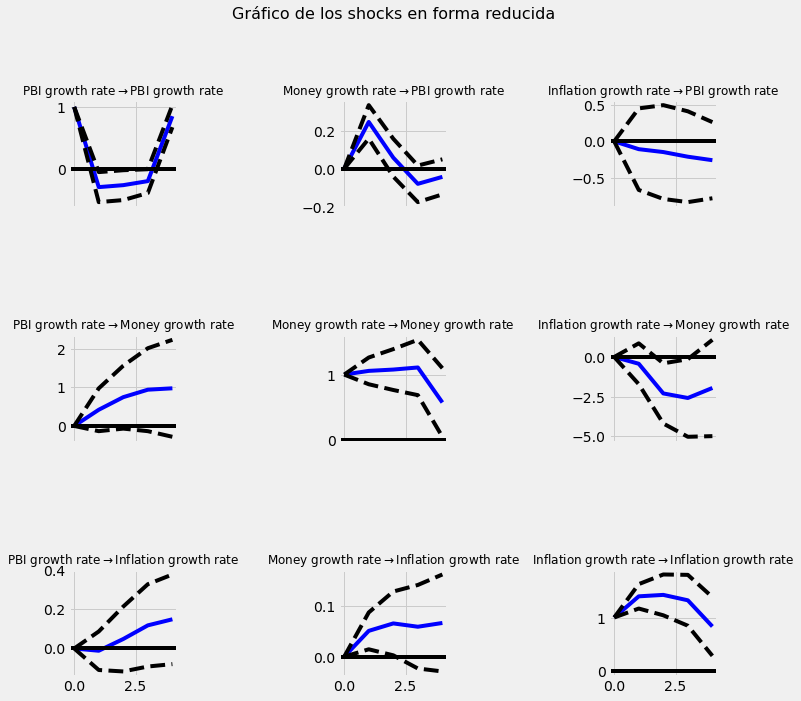

In [236]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.irf.IRAnalysis.html
irf = model_fitted.irf(4)
irf.plot(orth=False)
plt.suptitle('Gráfico de los shocks en forma reducida', fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.subplots_adjust(top=0.85, hspace=1.2, wspace=1.5)
plt.show()

## Forecast 

In [91]:
display(data)

PBI growth rate  Money growth rate  Inflation growth rate
1993-03-31         7.963215          74.319407              55.333852
1993-06-30         7.963215          55.271516              51.888179
1993-09-30        -2.339225          48.103168              48.117084
1993-12-31         1.513254          48.201038              41.589685
1994-03-31         4.889352          45.294636              33.680984
...                     ...                ...                    ...
2013-09-30         0.578179          13.196235               3.116177
2013-12-31         4.648166           8.139333               2.951101
2014-03-31        -8.639825           4.731967               3.407952
2014-06-30         5.353968           3.703187               3.509484
2014-09-30         0.444469           2.975667               3.331164

[87 rows x 3 columns]

In [93]:
# 2 años: 8 trimestres
fct_periods = 8
lag_order=5
nobs        = len(data)
y_df        = data
df_test = pd.DataFrame(columns=y_df.columns)
fct_input = y_df.values[-lag_order:]
model_forecast = model_fitted.forecast(y=fct_input, steps=fct_periods)
dates = ['2014-12-30', '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31', '2016-06-30', '2016-09-30']
df_fct = pd.DataFrame(model_forecast, index=pd.to_datetime(dates, format='%Y-%m-%d') , columns=y_df.columns + '_fct')
display(df_fct)

PBI growth rate_fct  Money growth rate_fct  \
2014-12-30             5.415493               5.556135   
2015-03-31            -7.434843               8.471516   
2015-06-30             5.795186              10.627792   
2015-09-30             0.116805              13.247666   
2015-12-31             5.864825              13.760640   
2016-03-31            -7.036394              13.111937   
2016-06-30             5.235213              12.875257   
2016-09-30            -0.574993              12.093184   

            Inflation growth rate_fct  
2014-12-30                   3.202613  
2015-03-31                   3.015907  
2015-06-30                   2.806712  
2015-09-30                   2.606750  
2015-12-31                   2.435017  
2016-03-31                   2.322593  
2016-06-30                   2.210446  
2016-09-30                   2.191346

Graficamos datos reales y forecast con su IC.

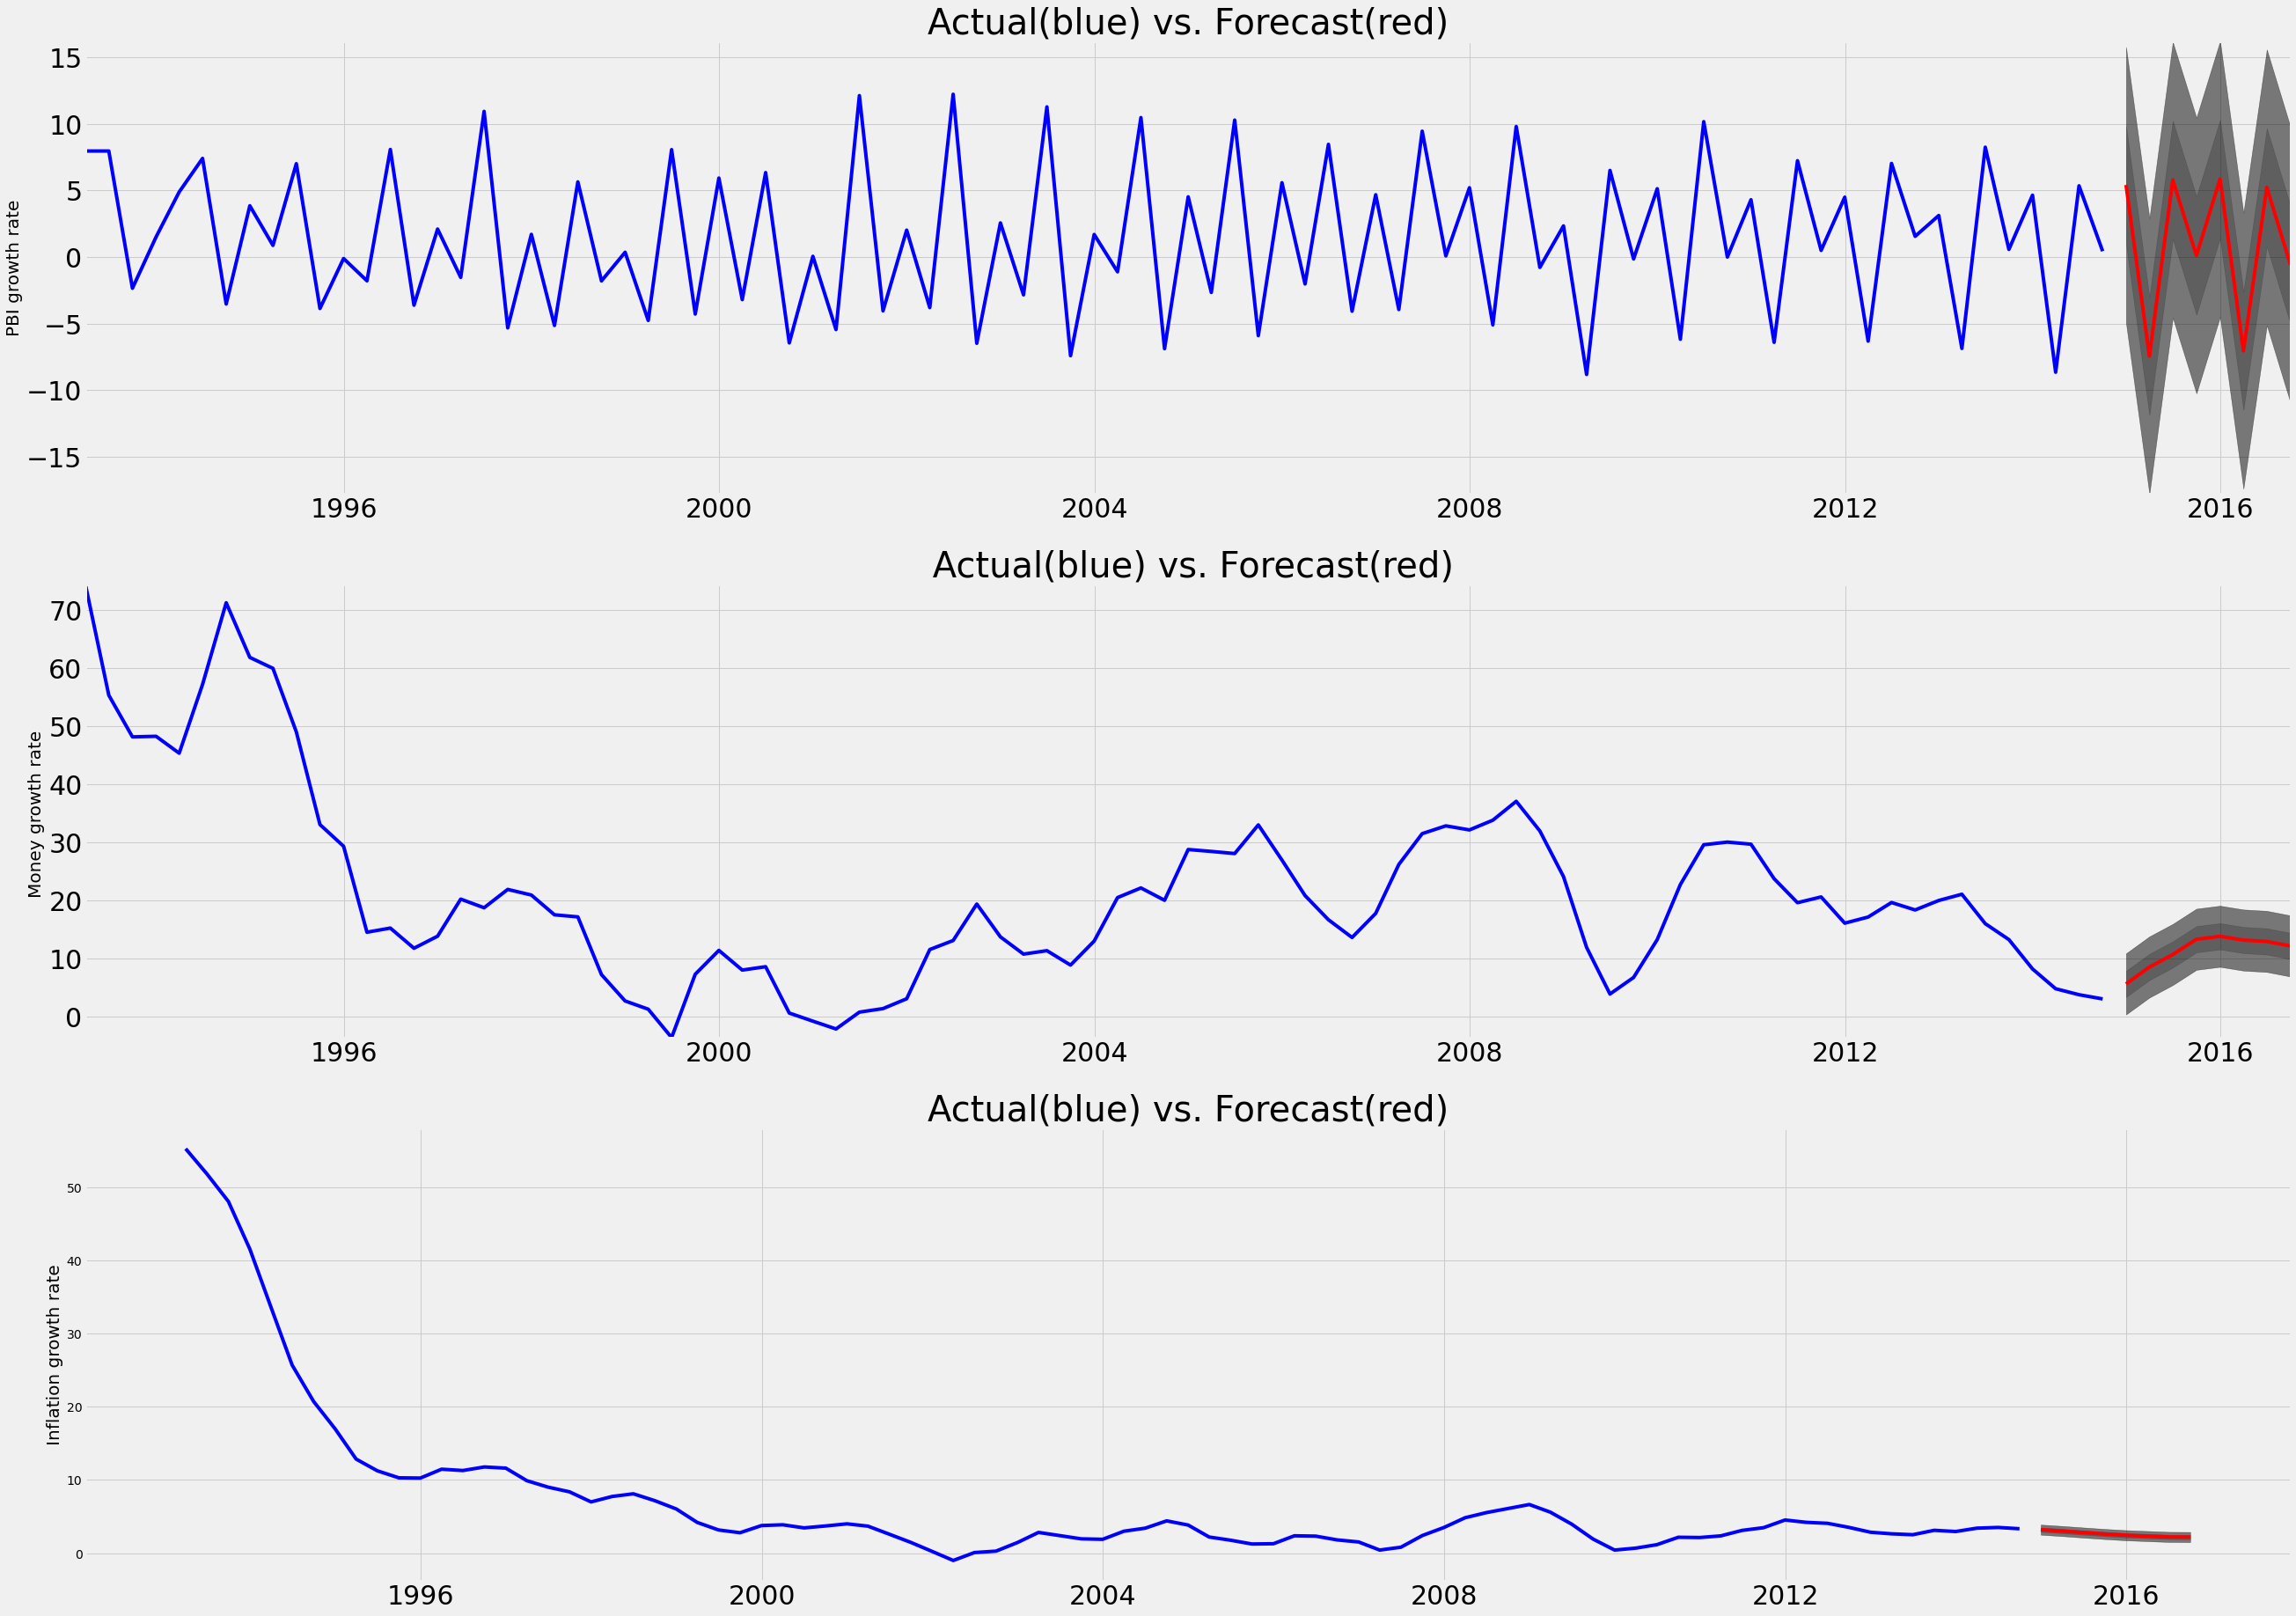

In [94]:



forecast = df_fct.values
stddev = np.std(model_forecast, axis=0)

# Intervalos
lower_95 = forecast - 1.96 * stddev
upper_95 = forecast + 1.96 * stddev
lower_80 = forecast - norm.ppf(0.8) * stddev
upper_80 = forecast + norm.ppf(0.8) * stddev

# ploteando actual hasta 2014-T3 y los 8 periodos siguientes del forecast
fig = plt.figure(figsize=(40, 30))


ax1 = plt.subplot(3, 1, 1, frameon=True) 
ax1.plot(y_df.index, y_df['PBI growth rate'], color='b')
ax1.plot(df_fct.index, df_fct['PBI growth rate'+ '_fct'], color='r')
ax1.set_title('Actual(blue) vs. Forecast(red)', fontsize=40)
ax1.set_ylabel('PBI growth rate', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='both', tight=True)

ax2 = plt.subplot(3, 1, 2, frameon=True) 
ax2.plot(y_df.index, y_df['Money growth rate'], color='b')
ax2.plot(df_fct.index, df_fct['Money growth rate'+ '_fct'], color='r')
ax2.set_title(' Actual(blue) vs. Forecast(red)', fontsize=40)
ax2.set_ylabel('Money growth rate ', fontsize=20)
ax2.tick_params(axis='x', labelsize=30)
ax2.tick_params(axis='y', labelsize=30)
ax2.autoscale(enable=True, axis='both', tight=True)

ax3 = plt.subplot(3, 1, 3, frameon=True) 
ax3.plot(y_df.index, y_df['Inflation growth rate'], color='b')
ax3.plot(df_fct.index, df_fct['Inflation growth rate'+ '_fct'], color='r')
ax3.set_title('Actual(blue) vs. Forecast(red)', fontsize=40)
ax3.set_ylabel('Inflation growth rate', fontsize=20)
ax3.tick_params(axis='x', labelsize=30)


# Inrervalos de confianza 95 y 85
ax1.fill_between(df_fct.index, lower_95[:,0], upper_95[:,0], color='black', alpha=0.5)
ax1.fill_between(df_fct.index, lower_80[:,0], upper_80[:,0], color='black', alpha=0.2)
ax2.fill_between(df_fct.index, lower_95[:,1], upper_95[:,1], color='black', alpha=0.5)
ax2.fill_between(df_fct.index, lower_80[:,1], upper_80[:,1], color='black', alpha=0.2)
ax3.fill_between(df_fct.index, lower_95[:,2], upper_95[:,2], color='black', alpha=0.5)
ax3.fill_between(df_fct.index, lower_80[:,2], upper_80[:,2], color='black', alpha=0.2)




## Forecast simultáneo

In [96]:
display(data)

PBI growth rate  Money growth rate  Inflation growth rate
1993-03-31         7.963215          74.319407              55.333852
1993-06-30         7.963215          55.271516              51.888179
1993-09-30        -2.339225          48.103168              48.117084
1993-12-31         1.513254          48.201038              41.589685
1994-03-31         4.889352          45.294636              33.680984
...                     ...                ...                    ...
2013-09-30         0.578179          13.196235               3.116177
2013-12-31         4.648166           8.139333               2.951101
2014-03-31        -8.639825           4.731967               3.407952
2014-06-30         5.353968           3.703187               3.509484
2014-09-30         0.444469           2.975667               3.331164

[87 rows x 3 columns]

In [99]:
fct_periods = 8
nobs        = len(data)
y_df        = data.iloc[0:nobs-fct_periods,:]
df_test     = data.iloc[-fct_periods:,:]

# El modelo VAR(2) en la seccion anterior
lag_order    = 5
model        = VAR(y_df)
model_fitted = model.fit(lag_order) # Estimamos un modelo con 4 rezagos

# Obtenemos el input data para el forecast
fct_input = y_df.values[-lag_order:]
model_forecast = model_fitted.forecast(y=fct_input, steps=fct_periods)

# Ponemos en formato Pandas
df_fct = pd.DataFrame(model_forecast, index = data.index[-fct_periods:], columns=data.columns + '_fct')

In [102]:
# Grafico: Forecast + Intervalos

p05         = model_fitted.forecast_interval(y=fct_input, steps=fct_periods,alpha = 0.05)
df_05_point = pd.DataFrame(p05[0], index = data.index[-fct_periods:], columns=data.columns + '_fct')
df_05_lower = pd.DataFrame(p05[1], index = data.index[-fct_periods:], columns=data.columns + '_fct')
df_05_upper = pd.DataFrame(p05[2], index = df.index[-fct_periods:], columns=data.columns + '_fct')

p20         = model_fitted.forecast_interval(y=fct_input, steps=fct_periods,alpha = 0.20)
df_20_point = pd.DataFrame(p20[0], index = data.index[-fct_periods:], columns=data.columns + '_fct')
df_20_lower = pd.DataFrame(p20[1], index = data.index[-fct_periods:], columns=data.columns + '_fct')
df_20_upper = pd.DataFrame(p20[2], index = data.index[-fct_periods:], columns=data.columns + '_fct')


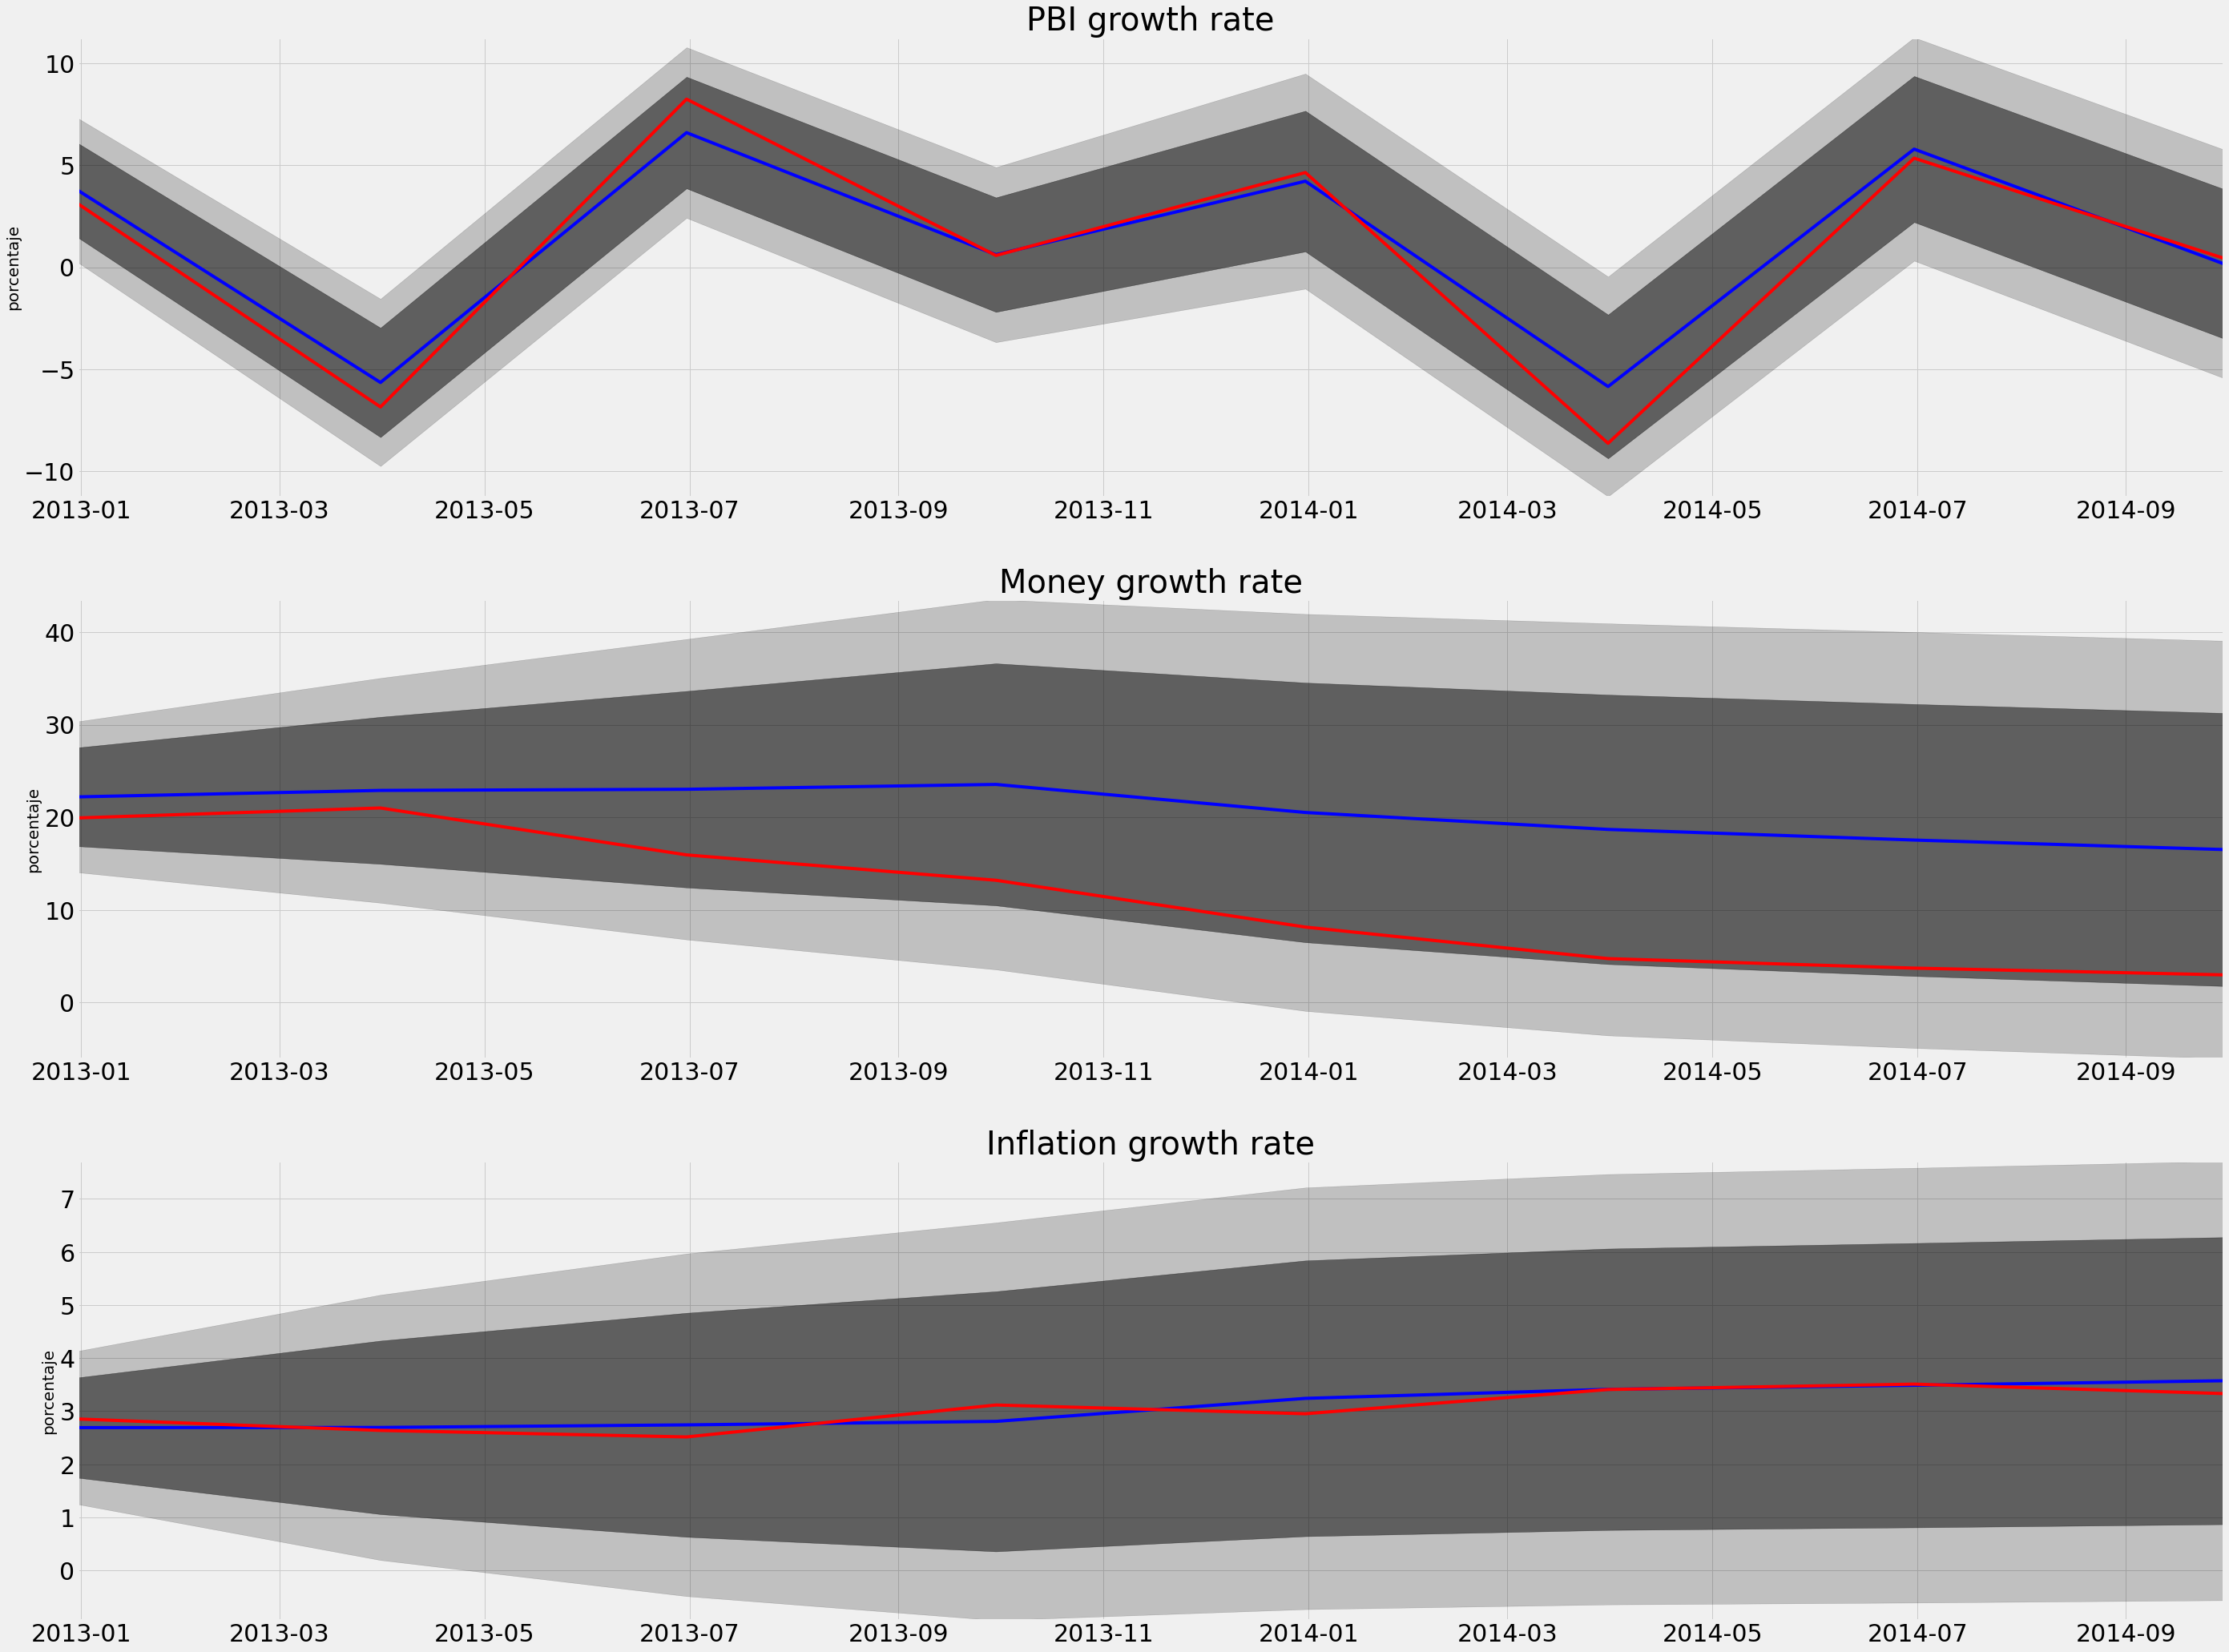

In [103]:
fig = plt.figure(figsize=(40, 30))

ax1 = plt.subplot(3, 1, 1, frameon=True) 
ax1.plot(df_05_point['PBI growth rate'+ '_fct'],color='b')
ax1.plot(df_test['PBI growth rate'],color='r')
ax1.set_title('PBI growth rate', fontsize=40)
ax1.set_ylabel('porcentaje', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='both', tight=True)

ax1.fill_between(df_20_lower.index,
                 df_20_lower['PBI growth rate'+ '_fct'],
                 df_20_upper['PBI growth rate'+ '_fct'], color='k', alpha=.5, label='80% CI')

ax1.fill_between(df_05_lower.index,
                 df_05_lower['PBI growth rate'+ '_fct'],
                 df_05_upper['PBI growth rate'+ '_fct'], color='k', alpha=.2, label='95% CI')


ax1 = plt.subplot(3, 1, 2, frameon=True) 
ax1.plot(df_05_point['Money growth rate'+ '_fct'],color='b')
ax1.plot(df_test['Money growth rate'],color='r')
ax1.set_title('Money growth rate', fontsize=40)
ax1.set_ylabel('porcentaje', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='both', tight=True)

ax1.fill_between(df_20_lower.index,
                 df_20_lower['Money growth rate'+ '_fct'],
                 df_20_upper['Money growth rate'+ '_fct'], color='k', alpha=.5, label='80% CI')

ax1.fill_between(df_05_lower.index,
                 df_05_lower['Money growth rate'+ '_fct'],
                 df_05_upper['Money growth rate'+ '_fct'], color='k', alpha=.2, label='95% CI')


ax1 = plt.subplot(3, 1, 3, frameon=True) 
ax1.plot(df_05_point['Inflation growth rate'+ '_fct'],color='b')
ax1.plot(df_test['Inflation growth rate'],color='r')
ax1.set_title('Inflation growth rate', fontsize=40)
ax1.set_ylabel('porcentaje', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='both', tight=True)

ax1.fill_between(df_20_lower.index,
                 df_20_lower['Inflation growth rate'+ '_fct'],
                 df_20_upper['Inflation growth rate'+ '_fct'], color='k', alpha=.5, label='80% CI')

ax1.fill_between(df_05_lower.index,
                 df_05_lower['Inflation growth rate'+ '_fct'],
                 df_05_upper['Inflation growth rate'+ '_fct'], color='k', alpha=.2, label='95% CI')

fig.tight_layout(pad=4.0)

## FIR estructurales y MSPE 

Asumimos que $B_0^{-1}$ es no singular y admite una descomposición a lo Cholesky.


$$y_t = \underbrace{B_0^{-1}B_1}_{=A_1}y_{t-1} + \cdots + \underbrace{B_0^{-1}B_p}_{=A_p} y_{t-p} + \underbrace{B_0^{-1}w_t}_{=u_t}.$$


Como $u_t=B_{0}^{-1}w_t$, podemos expresar los shocks correlacionados de la forma reducida como promedios ponderados de los shocks no correlacionados estructurales.

Entonces dado $y_t = (y_{1t}, ..., y_{Kt})^{T}$ y $w_t = (w_{1t}, ..., w_{Kt})^{T}$, definimos la matriz
\begin{equation*}
  \frac{\partial y_{t+i}}{\partial w_{t}^T} = \Theta_i, \ i=0, 1, 2, ..., H.
\end{equation*}
Nos interesa el efecto marginal de los shocks $h$ periodos al frente. Luego, notemos que
\begin{equation*}
\Theta_i = [\theta_{jk, i}] = \left[\frac{\partial y_{j, t+i}}{\partial k} \right] = \begin{bmatrix}
                              \frac{\partial y_{1, t+i}}{\partial w_{1t}} &\frac{\partial y_{1, t+i}}{\partial w_{2t}} & \cdots & \frac{\partial y_{1, t+i}}{\partial w_{Kt}} \\
                              \vdots & \ddots &  & \vdots \\
                                \vdots &  & \ddots &  \vdots  \\
                              \frac{\partial y_{K, t+i}}{\partial w_{1t}} &  &  &  \frac{\partial y_{K, t+i}}{\partial w_{Kt}}
                            \end{bmatrix}_{K \times K}.
\end{equation*}


Consideremos la siguiente representación VAR$(1)$ del VAR$(p)$
\begin{equation*}
  Y_t = AY_{t-1} + U_t
\end{equation*}
donde
\begin{equation*}
  Y_t = \begin{pmatrix}
          y_t \\
          y_{t-1} \\
          \vdots\\
          y_{t-p+1}
        \end{pmatrix}_{Kp\times 1}, \ \nu = \begin{pmatrix}
                                              \nu_0 \\
                                              0 \\
                                              \vdots\\
                                              0
                                            \end{pmatrix}, \ A =\begin{pmatrix}
                                               A_1 & A_2 & \cdots & A_p \\
                                               I_k & 0 & \cdots & 0 \\
                                               \vdots & \ddots &  &  \vdots \\
                                               0 &  & I_K & 0
                                             \end{pmatrix}, \ U_t = \begin{pmatrix}
                                                 u_t \\
                                                 0 \\
                                                 \vdots \\
                                                 0
                                               \end{pmatrix}.
\end{equation*}
Luego,
\begin{equation*}
  Y_{t+i} = A^{i+1}Y_{t-1} + \sum_{j=0}^{i}A^j U_{t+i-j}.
\end{equation*}
Multiplicamos por $J = [I_K, 0_{K \times K(p-1)}]$
\begin{align*}
  y_{t+i} & = JA^{i+1}Y_{t-1} + \sum_{j=0}^{i}JA^jU_{t+i-j} \\
          & = JA^{i+1}Y_{t-1} + \sum_{j=0}^{i} JA^jJ^TJU_{t+i-j}\\
          & = JA^{i+1}Y_{t-1} + \sum_{j=0}^{i} JA^jJ^Tu_{t+i-j}.
\end{align*}
Por lo tanto, la respuesta de la variable $j=1, ..., K$ en el VAR$(p)$ a una unidad del shock $u_{kt}$, $k=1, ..., K$ i periodo atrás es
\begin{equation*}
  \Phi_i = JA^iJ^T.
\end{equation*}
Asimismo, 
\begin{equation*}
  y_t = \sum_{i=0}^{\infty}\Phi_iu_{t-i} = \sum_{i=0}^{\infty}\Phi_iB_0^{-1}B_0u_{t-i} = \sum_{i=0}^{\infty}\Theta_i w_{t-i}.
\end{equation*}
Por ende,
\begin{equation*}
  \frac{\partial y_t}{\partial w_{t-i}^T} = \frac{\partial y_{t+i}}{\partial w_{t}^T}= \Theta_i = \Phi_iB_0^{-1}.
\end{equation*}


Usamos el código que nos provee las funciones FIR siguiendo las deficiones previas. Asimismo, el siguiente código provee una función que permite estimar un VAR por MCO (sin usar el fit integrado por Python), así como la descomposicion MSPE:

\begin{align*}
  MSPE(h) & = \mathbb{E}[(y_{t+h}-y_{t+h|t})(y_{t+h}-y_{t+h|t})^{T}]\\
  & = \sum_{i=0}^{h-1}\Phi_i\Sigma_u \Phi_i^{T}\\
  & = \sum_{i=0}^{h-1}\Phi_iB_0^{-1}\Sigma_{w} (B_0^{-1})^{T}\Phi_i^{T}\\
& = \sum_{i=0}^{h-1}\Theta_i \Theta_i^{T}.
\end{align*}

In [237]:
## Estimación del VAR en forma reducida ##

h_ = 8          # Horizonte máximo para las FIR
p_ = 5      # Orden de rezagos

# Estimar VAR por MCO (ver función en la sección 0.)
A0,A1,Sig,Sig_ML,U,Z,K,T = var_mco(data, p=p_)

# FIR estructural (ver función en la sección 0.)
FIR0, B0 = FIR(A1,Sig,p_,h_,K)

## Shocks de demanda

(0.0, 9.0)

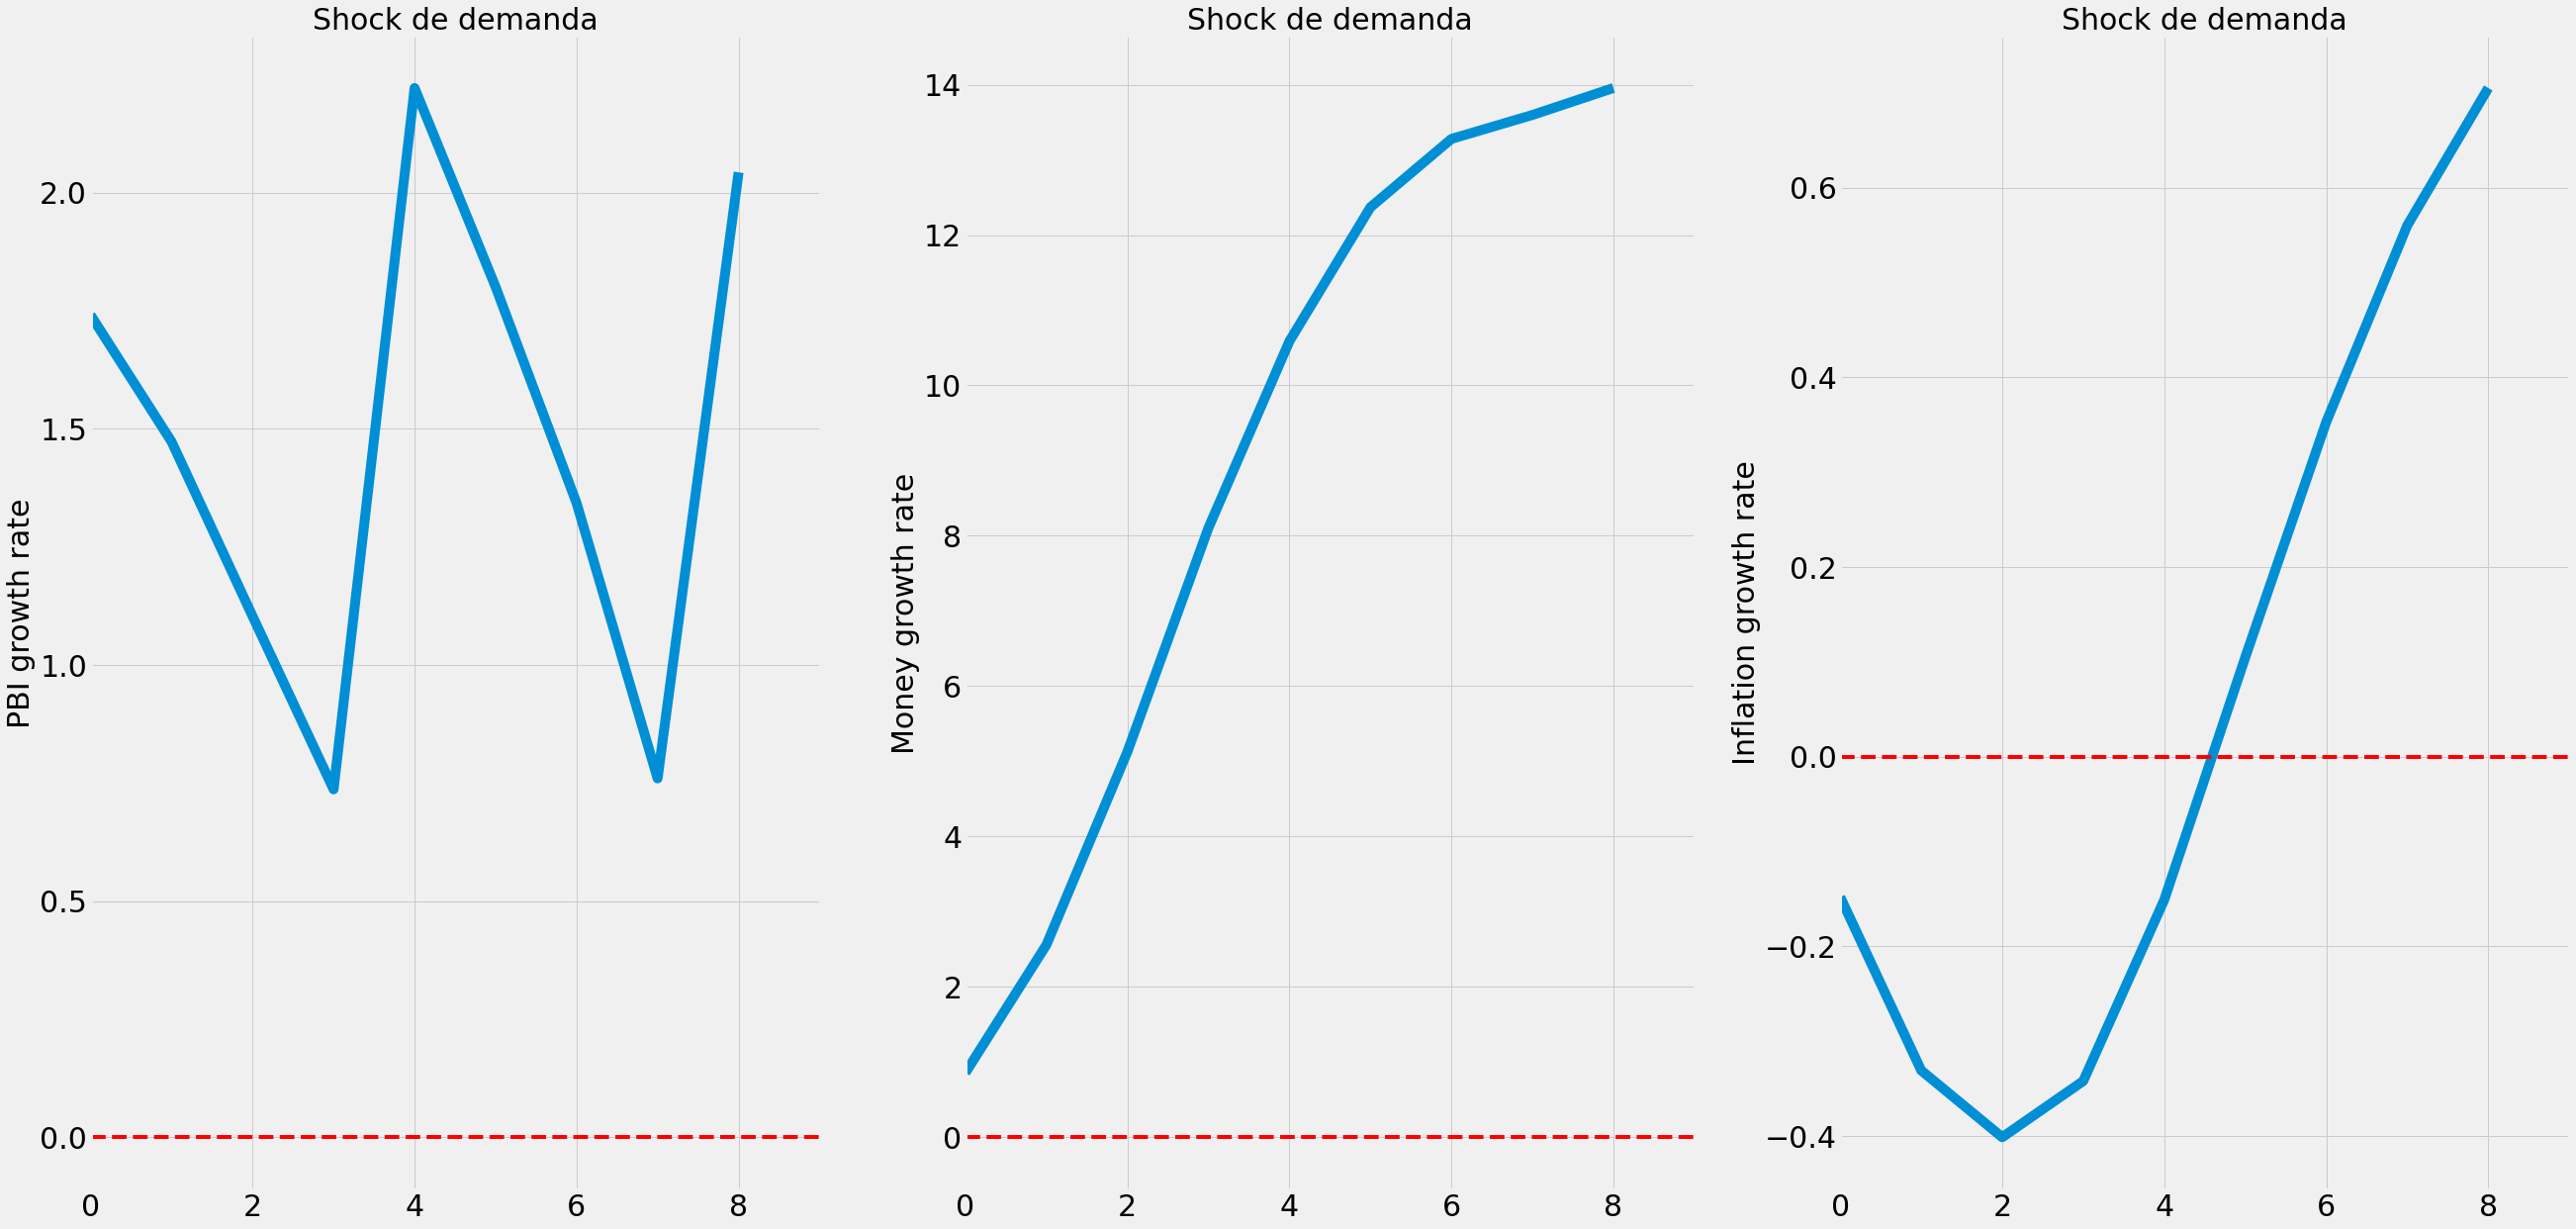

In [115]:

# FIR acumuladas
FIR0_1  = np.cumsum(FIR0[0,:])
FIR0_2  = np.cumsum(FIR0[1,:])
FIR0_3 =  np.cumsum(FIR0[2, :])

fig = plt.figure(figsize=(40, 20))

ax1 = plt.subplot(1,3,1, frameon=True) 
ax1.plot(FIR0_1, linewidth=10)
ax1.axhline(y=0, color="r",linestyle='--')
ax1.set_title('Shock de demanda', fontsize=30)
ax1.set_ylabel('PBI growth rate', fontsize=30)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
#ax1.set_ylim([-2, 2])
ax1.set_xlim([0, 9])

ax1 = plt.subplot(1,3,2, frameon=True) 
ax1.plot(FIR0_2, linewidth=10)
ax1.axhline(y=0, color="r",linestyle='--')
ax1.set_title('Shock de demanda', fontsize=30)
ax1.set_ylabel('Money growth rate', fontsize=30)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
#ax1.set_ylim([-5, 5])
ax1.set_xlim([0, 9])

ax1 = plt.subplot(1,3,3, frameon=True) 
ax1.plot(FIR0_3, linewidth=10)
ax1.axhline(y=0, color="r",linestyle='--')
ax1.set_title('Shock de demanda', fontsize=30)
ax1.set_ylabel('Inflation growth rate', fontsize=30)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
#ax1.set_ylim([-5, 5])
ax1.set_xlim([0, 9])

## Shocks de politica monetaria

(0.0, 9.0)

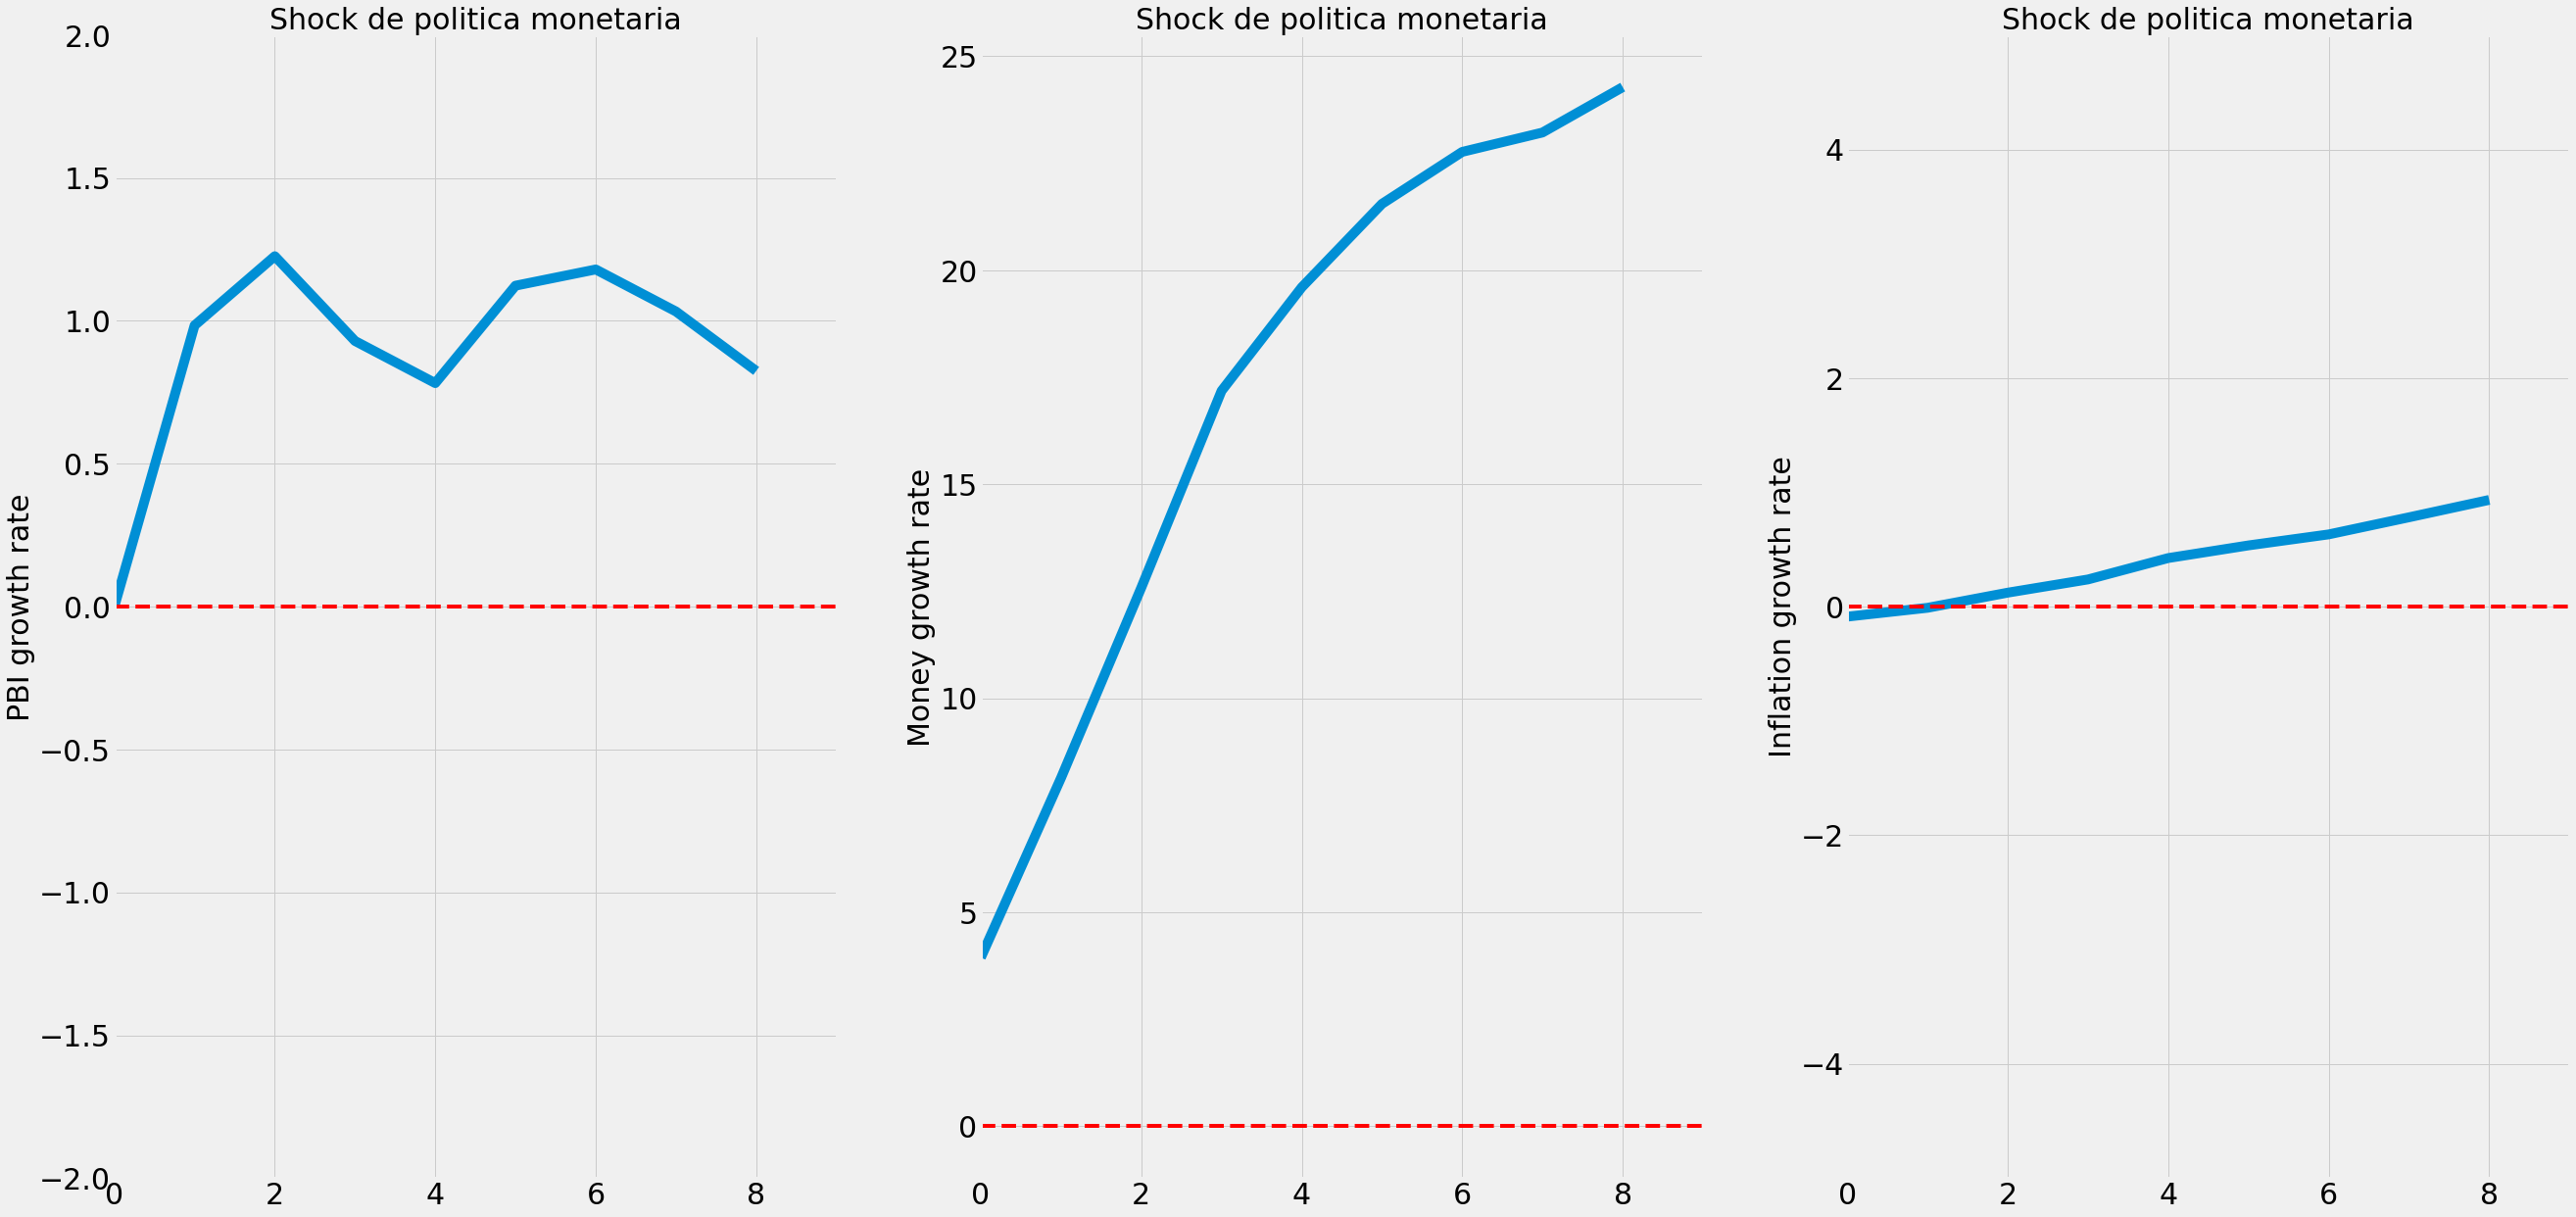

In [116]:

# FIR acumuladas
FIR0_1  = np.cumsum(FIR0[3,:])
FIR0_2  = np.cumsum(FIR0[4,:])
FIR0_3 =  np.cumsum(FIR0[5, :])

fig = plt.figure(figsize=(40, 20))

ax1 = plt.subplot(1,3,1, frameon=True) 
ax1.plot(FIR0_1, linewidth=10)
ax1.axhline(y=0, color="r",linestyle='--')
ax1.set_title('Shock de politica monetaria', fontsize=30)
ax1.set_ylabel('PBI growth rate', fontsize=30)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.set_ylim([-2, 2])
ax1.set_xlim([0, 9])

ax1 = plt.subplot(1,3,2, frameon=True) 
ax1.plot(FIR0_2, linewidth=10)
ax1.axhline(y=0, color="r",linestyle='--')
ax1.set_title('Shock de politica monetaria', fontsize=30)
ax1.set_ylabel('Money growth rate', fontsize=30)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
#ax1.set_ylim([-5, 5])
ax1.set_xlim([0, 9])

ax1 = plt.subplot(1,3,3, frameon=True) 
ax1.plot(FIR0_3, linewidth=10)
ax1.axhline(y=0, color="r",linestyle='--')
ax1.set_title('Shock de politica monetaria', fontsize=30)
ax1.set_ylabel('Inflation growth rate', fontsize=30)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.set_ylim([-5, 5])
ax1.set_xlim([0, 9])

## Shocks de inflación

(0.0, 9.0)

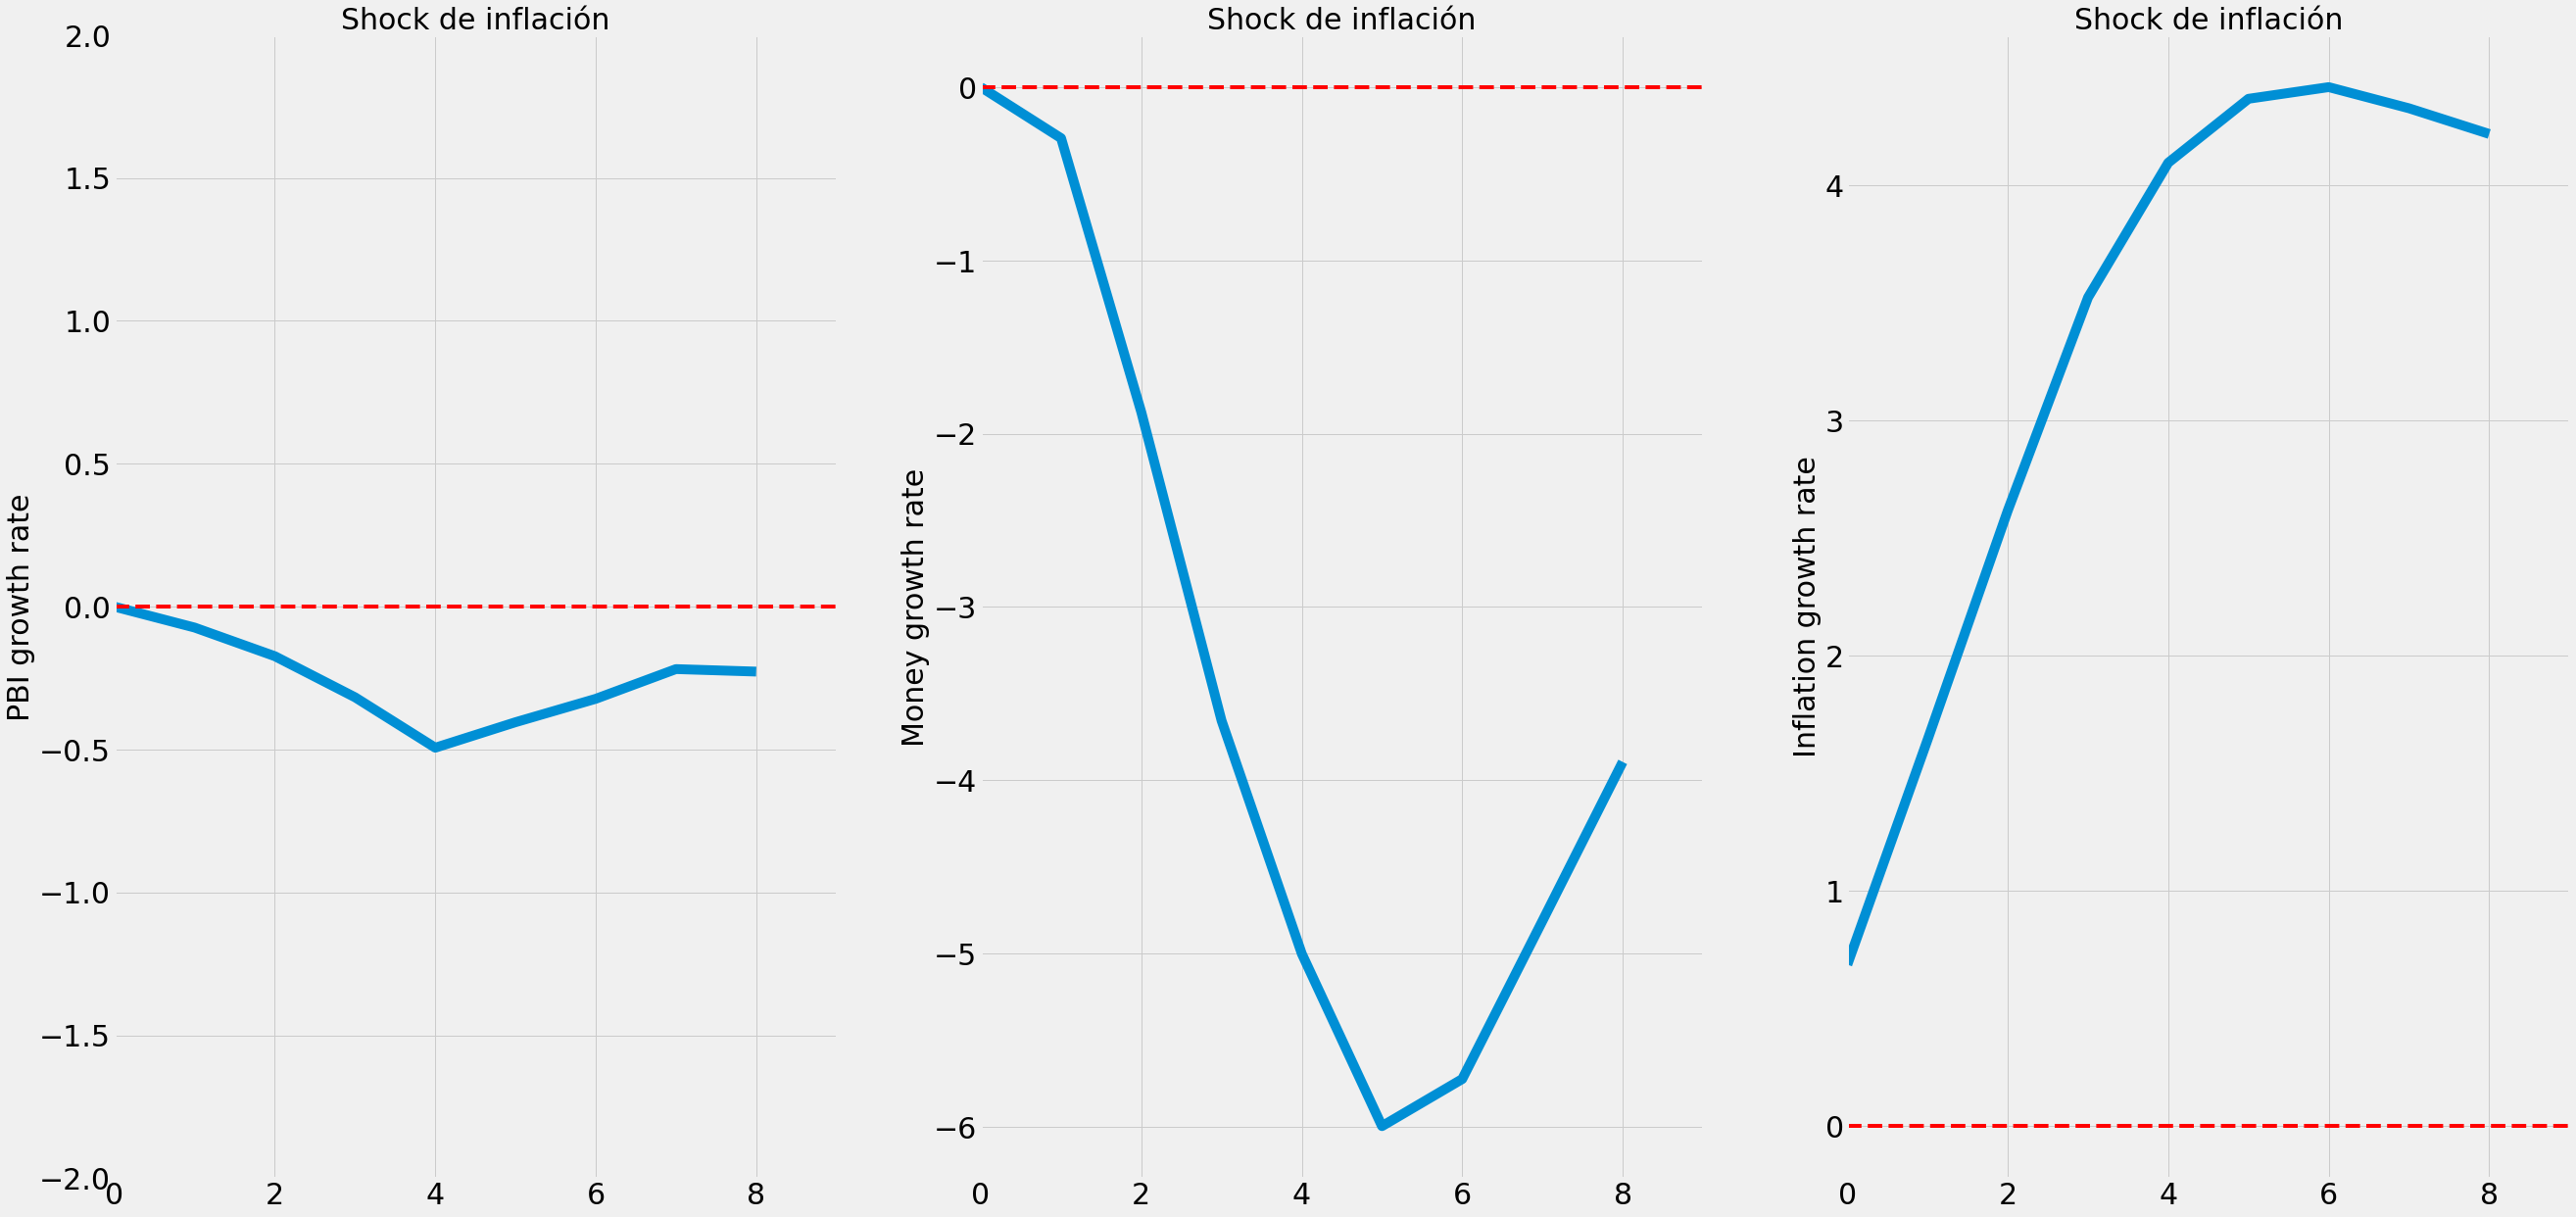

In [117]:

# FIR acumuladas
FIR0_1  = np.cumsum(FIR0[6,:])
FIR0_2  = np.cumsum(FIR0[7,:])
FIR0_3 =  np.cumsum(FIR0[8, :])

fig = plt.figure(figsize=(40, 20))

ax1 = plt.subplot(1,3,1, frameon=True) 
ax1.plot(FIR0_1, linewidth=10)
ax1.axhline(y=0, color="r",linestyle='--')
ax1.set_title('Shock de inflación', fontsize=30)
ax1.set_ylabel('PBI growth rate', fontsize=30)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.set_ylim([-2, 2])
ax1.set_xlim([0, 9])

ax1 = plt.subplot(1,3,2, frameon=True) 
ax1.plot(FIR0_2, linewidth=10)
ax1.axhline(y=0, color="r",linestyle='--')
ax1.set_title('Shock de inflación', fontsize=30)
ax1.set_ylabel('Money growth rate', fontsize=30)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
#ax1.set_ylim([-5, 5])
ax1.set_xlim([0, 9])

ax1 = plt.subplot(1,3,3, frameon=True) 
ax1.plot(FIR0_3, linewidth=10)
ax1.axhline(y=0, color="r",linestyle='--')
ax1.set_title('Shock de inflación', fontsize=30)
ax1.set_ylabel('Inflation growth rate', fontsize=30)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
#ax1.set_ylim([-5, 5])
ax1.set_xlim([0, 9])

In [119]:
# Para h=1
MSPE_1   = np.round_(MSPE(A1,Sig,K,p_,1)[K-1,:], decimals=1)

# Para h=2
MSPE_2   = np.round_(MSPE(A1,Sig,K,p_,2)[K-1,:], decimals=1)

# Para h=3
MSPE_3   = np.round_(MSPE(A1,Sig,K,p_,3)[K-1,:], decimals=1)

# Para h=12
MSPE_12  = np.round_(MSPE(A1,Sig,K,p_,12)[K-1,:], decimals=1)

# Para h=inf
MSPE_inf = np.round_(MSPE(A1,Sig,K,p_,1000)[K-1,:], decimals=1)

MSPE_table = pd.DataFrame({'Horizon':[1,2,3,12,'inf'],
                           'Shock crecimiento PBI': [MSPE_1[0], MSPE_2[0], MSPE_3[0], MSPE_12[0], MSPE_inf[0]],
                           'Shock politica monetaria': [MSPE_1[1], MSPE_2[1], MSPE_3[1], MSPE_12[1], MSPE_inf[1]],
                           'Shock residual': [MSPE_1[2], MSPE_2[2], MSPE_3[2], MSPE_12[2], MSPE_inf[2]],
                          })
MSPE_table.set_index(['Horizon'], inplace=True)
MSPE_table

Shock crecimiento PBI  Shock politica monetaria  Shock residual
Horizon                                                                 
1                          4.4                       1.5            94.1
2                          3.8                       0.9            95.3
3                          2.5                       1.3            96.2
12                         7.9                       8.3            83.8
inf                        9.9                      13.5            76.6

## Descomposición histórica

In [122]:
## Estimación del VAR en forma reducida ##

p_ = 5       # Orden de rezagos

# Estimar VAR por MCO
A0,A1,Sig,Sig_ML,U_hat,Z,K,T = var_mco(data,p=p_)

# Obtener la FIR estructural usando Cholesky
h_          = T-p_-1
FIR0, B0inv = FIR(A1,Sig,p_,h_,K)

# Obtener los shocks estructurales
W_hat = np.dot(np.linalg.inv(B0inv),U_hat[0:K,:])

# Matrices para los valores de las variables y
yhat1,yhat2,yhat3,yhat4 = np.zeros(T-p_),np.zeros(T-p_),np.zeros(T-p_),np.zeros(T-p_)

for i in range(1,T-p_+1):
    yhat1[i-1] = np.dot(FIR0[0,0:i],  W_hat[0,np.arange(i-1, -1, -1)])
    yhat2[i-1] = np.dot(FIR0[3,0:i],  W_hat[1,np.arange(i-1, -1, -1)])
    yhat3[i-1] = np.dot(FIR0[6,0:i], W_hat[2,np.arange(i-1, -1, -1)])
    
y_hat = yhat1 + yhat2 + yhat3

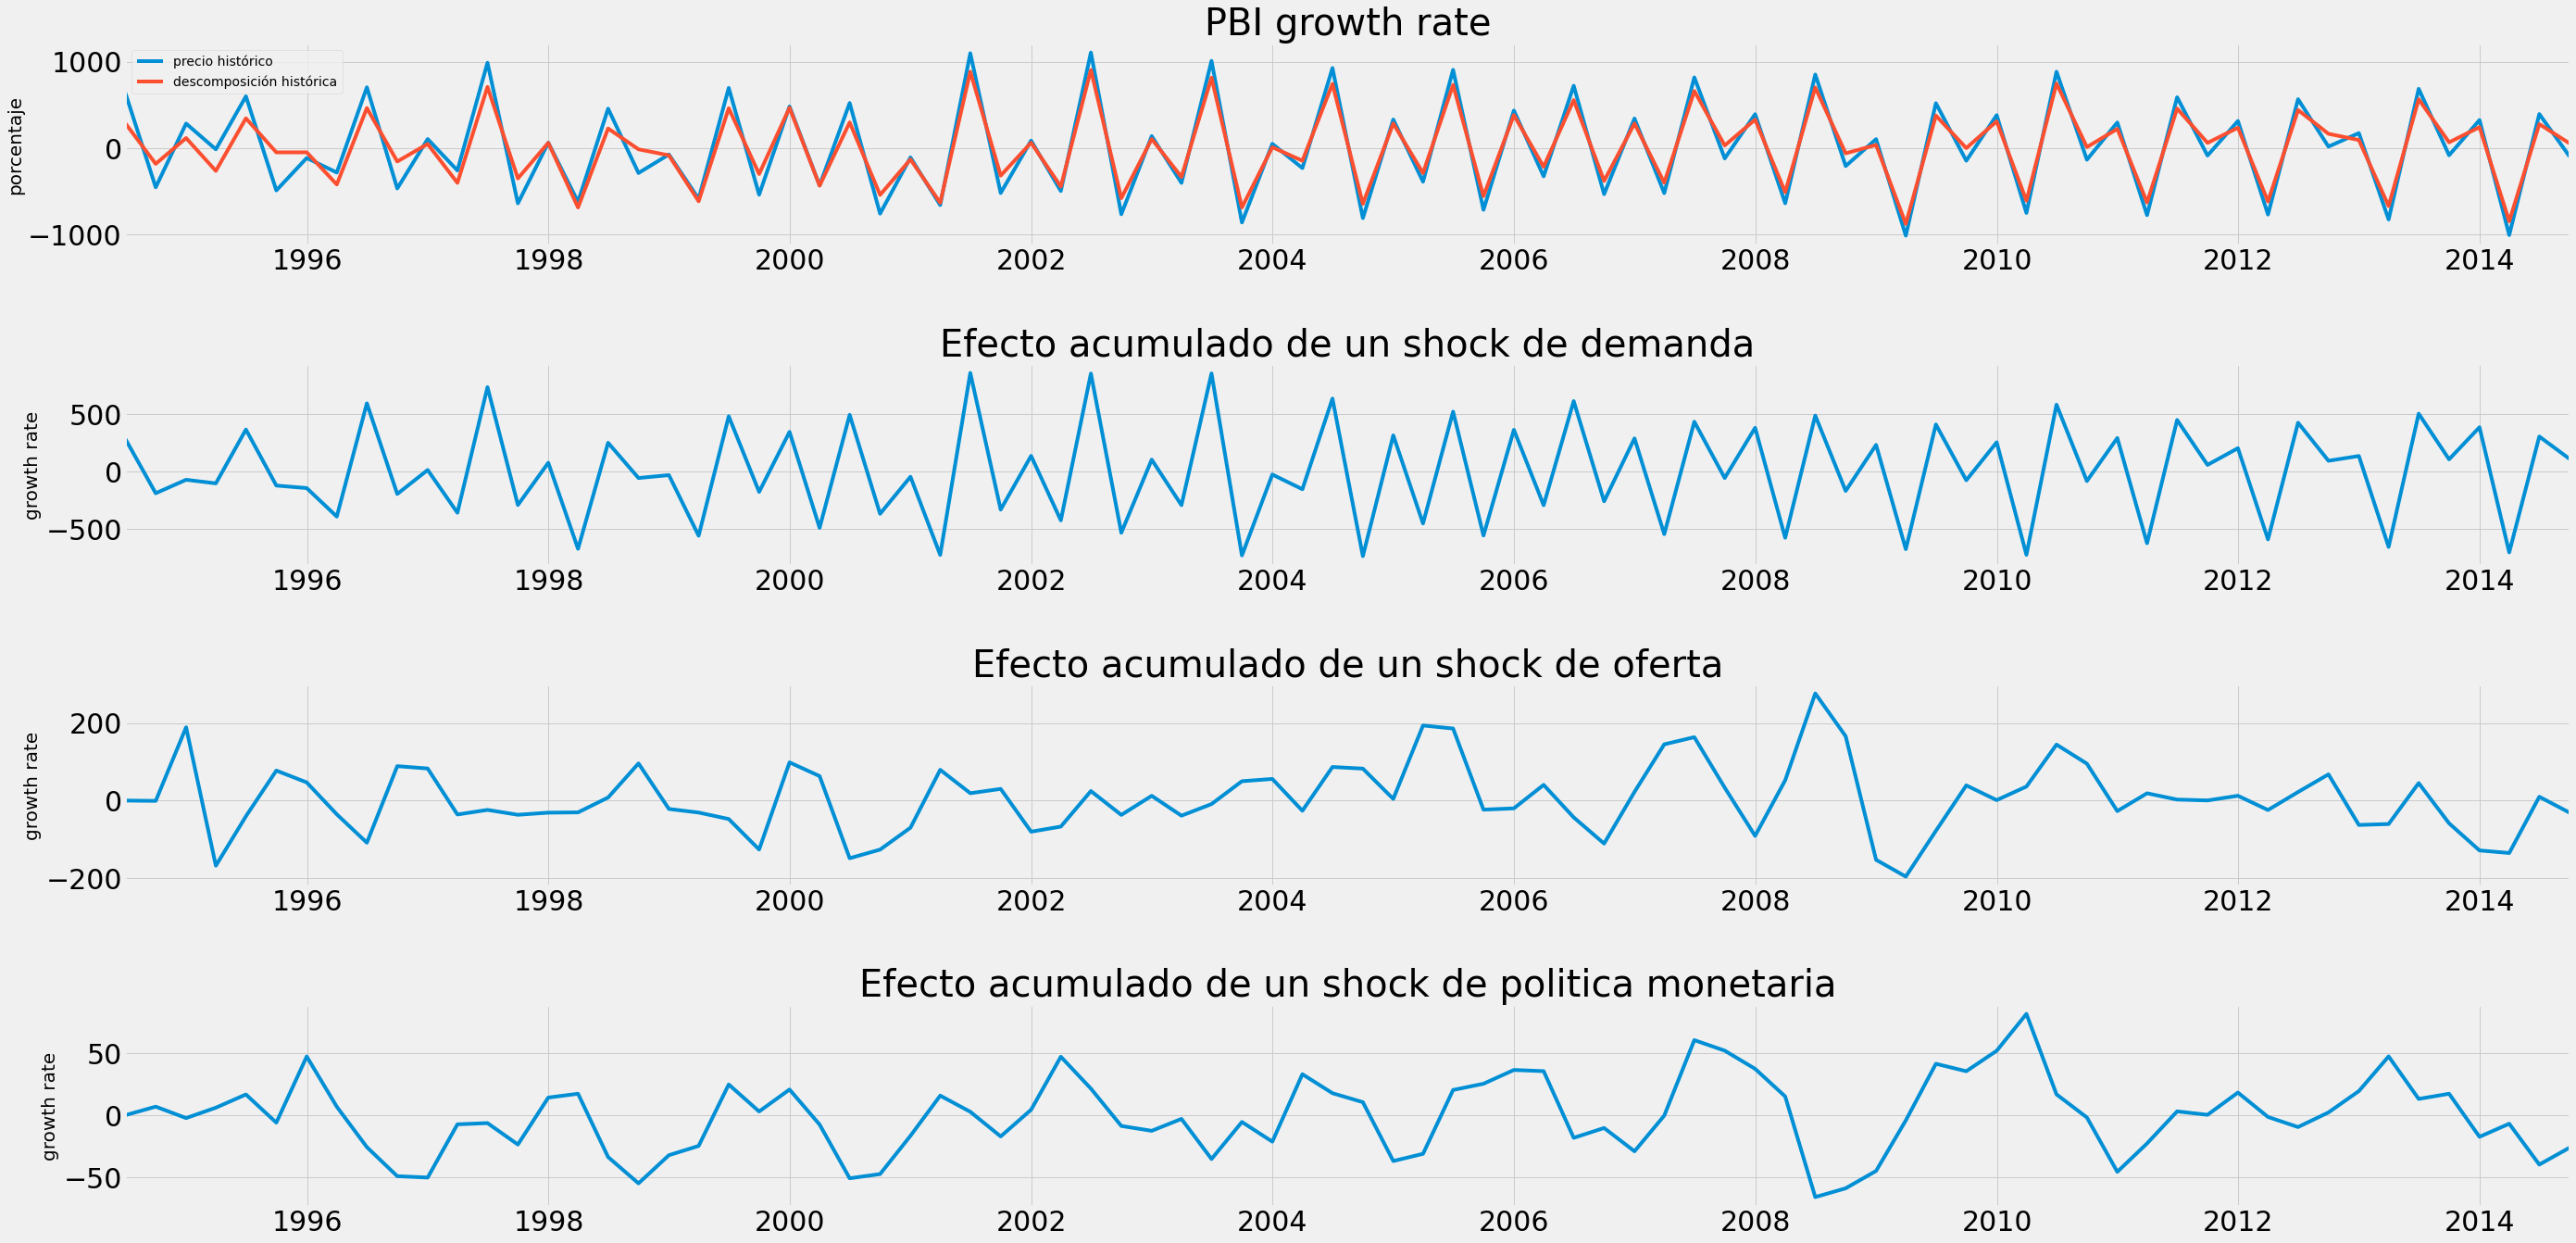

In [246]:
# Plots
# p =5
date = data.index[5:]

fig  = plt.figure(figsize=(40, 20))

ax1 = plt.subplot(4,1,1, frameon=True) 
ax1.plot(date, signal.detrend(data['PBI growth rate'].values[5::])*100, label='precio histórico')
ax1.plot(date, y_hat*100, label='descomposición histórica')
ax1.legend(loc="best")
ax1.set_title('PBI growth rate', fontsize=40)
ax1.set_ylabel('porcentaje', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='x', tight=True)
#ax1.set_ylim([-10, 10]) 

ax1 = plt.subplot(4,1,2, frameon=True) 
ax1.plot(date,yhat1*100)
ax1.set_title('Efecto acumulado de un shock de demanda', fontsize=40)
ax1.set_ylabel('growth rate', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='x', tight=True)
#ax1.set_ylim([-10, 10])

ax1 = plt.subplot(4,1,3, frameon=True) 
ax1.plot(date,yhat2*100)
ax1.set_title('Efecto acumulado de un shock de oferta', fontsize=40)
ax1.set_ylabel('growth rate', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='x', tight=True)
#ax1.set_ylim([-5, 5])

ax1 = plt.subplot(4,1,4, frameon=True) 
ax1.plot(date,yhat3*100)
ax1.set_title('Efecto acumulado de un shock de politica monetaria', fontsize=40)
ax1.set_ylabel('growth rate', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='x', tight=True)
#ax1.set_ylim([-5, 5])

fig.tight_layout(pad=4.0)

## Pregunta 2

Usando el modelo anterior, simule los quantiles de la respuesta de la $\textbf{tasa de inflación y la tasa de crecimiento del PBI a un shock de politica monetaria}$ para diferentes (tal y como vimos en clase):
-	Minnesota Priors
-	Gaussian-inverse Wishart
-	Independent Gaussian-inverse Wishart


Usamos el siguiente código proporcionado en clase.

In [492]:
display(data)

PBI growth rate  Money growth rate  Inflation rate
0          0.062393           0.020955        0.052413
1         -0.019263           0.067498        0.033992
2         -0.066201           0.028319        0.029744
3          0.007304           0.310345        0.036758
4         -0.002467          -0.113870        0.040053
..              ...                ...             ...
86         0.052266           0.070721        0.004001
87         0.068444          -0.035957       -0.000047
88         0.049559          -0.031178        0.004787
89         0.019594           0.026858        0.002591
90         0.018232           0.089140        0.004333

[91 rows x 3 columns]

La prior de Minnesota busca reducir las estimaciones del VAR hacia
un modelo de paseo aleatorio multivariado. Este tipo de prior es útil para hacer predicciones cuando se trabaja con series que son bastante persistentes.

En cada ecuación, fijar la media de la prior del primer rezago de la variable dependiente en uno y la media de los otros a cero. Es decir, asumiremos que cada variable sigue un paseo aleatorio. Luego, se asume que la varianza de la prior del intercepto es infinito y la varianza de la prior de los elementos ij-ésimos de la matriz de rezagos $A_{\ell}, a_{ij, \ell}$ es
\begin{equation*}
  v_{ij, \ell} = \begin{cases}
                   \left(\frac{\lambda}{\ell}\right)^2, & \mbox{si } \ i=j \\
                   \left( \frac{\lambda \theta \sigma_i}{\ell \sigma_j}\right)^2 & \mbox{caso contrario}.
                 \end{cases}
\end{equation*}
El parámetro $\lambda$ es la desviación estándar de la prior para $a_{ii}$, $0 < \theta < 1$ controla la rigidez relativa de la varianza de la prior en los otros rezagos en una ecuación dada en comparación con los rezagos propios, y $\sigma_i$ el elemento de la diagonal de $\Sigma_u$.


En el caso de un VAR(2)
\begin{align*}
  y_{1t} & = \underset{(\infty)}{0} + 1 \cdot \underset{(\lambda)}{y_{1, t-1}} + 0\cdot \underset{(\lambda \theta \sigma_1/\sigma_2)}{y_{2, t-1}} + 0 \cdot \underset{(\lambda/2)}{y_{1, t-2}} + 0 \cdot \underset{(\lambda \theta \sigma_1/2\sigma_2)}{y_{2, t-2}}+u_{1t}\\
  y_{2t} & = \underset{(\infty)}{0}  + 0 \cdot \underset{(\lambda \theta \sigma_2/\sigma_1)}{y_{1,t -1}} + 1 \cdot \underset{(\lambda)}{y_{2, t-1}} + 0 \cdot \underset{(\lambda \theta \sigma_2/2\sigma_1)}{y_{2, t-2}} + 0 \cdot \underset{(\lambda/2)}{y_{2, t-2}}+u_{2t}.
\end{align*}
La matriz $V_{\alpha}^{-1}$ es en este caso
\begin{equation*}
  V_{\alpha}^{-1} = \begin{bmatrix}
                                0 &  &  &  &  &  &  & &  &  \\
                                 & 0 &  & &  &  &  &  &  &  \\
                                 &  & 1/\lambda^2 &  &  &  &  &  & &  \\
                                 &  &  & \sigma_1^2/(\lambda \theta \sigma_2^2) &  &  &  &  & &  \\
                                 & &  &  & \sigma_2^2/(\lambda \theta \sigma_1^2) &  &  &  &  & \\
                                 &  & &  &  & 1/\lambda^2 &  &  & &  \\
                                 &  &  &  &  &  & 2^2/\lambda^2 & &  &  \\
                                 &  &  &  &  &  &  & 2^2\sigma_1^2/(\lambda \theta \sigma_2^2) &  &  \\
                                 &  &  &  &  &  &  &  & 2^2\sigma_2^2/(\lambda \theta \sigma_1^2) &  \\
                                 &  &  &  &&  &  &  &  & 2^2/\lambda^3
                              \end{bmatrix}
\end{equation*}


Podemos jugar con los parámetros, sobre todo $\lambda$ y $\theta$.

In [239]:
## --- GENERALES ---##
const_cond = 1;    # VAR con constante (1), VAR sin constante (0)
p_         = 5;    # Número de rezagos
impulso    = 1;    # Computar FIR (1), No computar FIR (0)
imp_h      = 8;   # Horizonte para las FIR
disp_iter  = 2000; # Cada cuantas iteraciones mostrar el tiempo de estimación

## --- MUESTREO  ---##
n_draw      = 10000           # Número de elementos a muestrear
n_burn      = 0               # Número de elementos a eliminar por condiciones iniciales
# dado que consideremos prios con distribuciones analitica, no es necesario quemar 

n_tot       = n_draw+n_burn   # Número total de elementos muestreados

## ---- Tipo de Prior --- ##
# testeo de lambda y theta para diferentes valores: cambiar aca
random_walk = 1 # Prior de Minnesota 
p_lambda    = 0.1     # parámetro lambda -> hiperparámetro para la prior de la Varianza de alpha
p_theta     = 0.5    # parámetro theta  -> hiperparámetro para la prior de la Varianza de alpha
p_varint    = 10**6  # parámetro varint -> varianza de la prior del intercepto: infinito 
MCO_VAR     = 0      # Si es 1, usamos SIGMA_u de MCO si es 0 usamos una matriz diagonal con elementos de la diagonal
                     # estimados usando un modelo AR(4) para cada variable

In [ ]:
# Parte del código común a las priors

In [240]:
df0 = data.copy(deep=True)
display(df0)

PBI growth rate  Money growth rate  Inflation growth rate
1993-03-31         7.963215          74.319407              55.333852
1993-06-30         7.963215          55.271516              51.888179
1993-09-30        -2.339225          48.103168              48.117084
1993-12-31         1.513254          48.201038              41.589685
1994-03-31         4.889352          45.294636              33.680984
...                     ...                ...                    ...
2013-09-30         0.578179          13.196235               3.116177
2013-12-31         4.648166           8.139333               2.951101
2014-03-31        -8.639825           4.731967               3.407952
2014-06-30         5.353968           3.703187               3.509484
2014-09-30         0.444469           2.975667               3.331164

[87 rows x 3 columns]

In [241]:
## --- CONSTRUCCIÓN DE MATRICES --- ##

# Dimensión de los datos
T0, K0   = np.shape(df0)
var_name = data.columns

# Matriz de rezagos 
for p_idx in range(1,p_+1):
    for idx in var_name:
        df0[idx+'_l'+str(p_idx)] = df0[idx].shift(p_idx)

# Añadir constante
if const_cond:
    df0['const'] = 1


# Eliminar los missings
df0.dropna(inplace=True)

# Matrices Y (dependientes) y X (rezagos de las dependientes + constante)
Y  = df0[var_name].values
X0 = df0.drop(columns=var_name)
fc = X0.pop('const')
X0.insert(0, 'const', fc)
X  = X0.values

# Dimensión de los datos en X
T1, K1   = np.shape(X)

# Creating the kron for matrix ZxI_K
# Z = np.kron(np.eye(K0), df_X0.values)
# producto kronecker 
Z = sparse.kron(np.eye(K0), X).toarray()

# Especificar las matrices donde almacenaremos los draws de las posteriors
alpha_draws = np.zeros((n_draw,K1*K0))    # Para la forma vectorial
ALPHA_draws = np.zeros((n_draw,K1,K0))    # Para la forma matricial
SIGMA_draws = np.zeros((n_draw,K0,K0))

# Especificar las matrices de impulso respuesta para CADA variable
imp_pbi = np.zeros((n_draw,K0,imp_h))  
imp_mon = np.zeros((n_draw,K0,imp_h))  
imp_inf = np.zeros((n_draw,K0,imp_h))  

In [128]:
np.shape(X[:, 0])
# 82 pues se descartan 5 lags (dado que p=5)

(82,)

In [242]:
## --- ESTIMADORES MCO --- ##

# Matrices de Rezagos y vectorización
A_MCO     = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))
a_MCO     = A_MCO.flatten('F') # Para hacer la vectorización columna por columna. 'C' es fila por fila
SSE_MCO   = np.dot((Y - np.dot(X,A_MCO)).T,(Y - np.dot(X,A_MCO))) # Suma de errores al cuadrado
SIGMA_MCO = SSE_MCO/(T1-K1+1);

# Matriz para inicializar el algoritmo Bayesiano
alpha     = a_MCO.copy();


In [469]:
# PRIOR MINNESOTA

In [243]:
## --- CONSTRUCCIÓN DE LA PRIOR MINNESOTA --- ##

# Primero creamos la media de la prior. Recuerden que el intercepto estará centrado en 0 (primer vector), 
# luego asumiremos que la media del primer rezago es 1 (random walk), eso quiere decir que tendremos 
# una matriz identidad KxK. Finalmente la media de los otros términos cruzados y rezagos estarán centrados en 0
# el tercer elemento del concatenar

# Parte 1: Prior de la Media en el VAR
if random_walk:
    A_prior = np.concatenate( (np.concatenate( (np.zeros((1,K0)),np.eye(K0)) ),
                                np.zeros(((p_-1)*K0,K0)) ) )
    a_prior = A_prior.flatten('F')
else:
    A_prior = np.concatenate( (np.concatenate( (np.zeros((1,K0)),np.zeros((K0,K0))) ),
                                np.zeros(((p_-1)*K0,K0)) ) ) 
    # vectorizamos
    a_prior = A_prior.flatten('F')

# Parte 2: Prior de la Varianza en el VAR
if MCO_VAR:
    # Usando la matriz obtenida por MCO
    SIGMA = SIGMA_MCO.copy()
else:
    # Usando la matriz obtenida por estimando ecuacion por ecuacion una regresion dinamica con p rezagos
    SIGMA = np.zeros((K0,K0))
    A_intercept, A_coeff, Sigma_Uaux, Sigma_MLaux, U_, Zaux, Kaux, Taux = var_mco(data,p=p_)
    
    for i in range(K0):
        SIGMA[i,i] = np.dot(U_[i,:],U_[i,:])/(T0-p_+1)

# Crear la matriz prior de la varianza
V_i     = np.zeros((K0,K0))

if const_cond:
    V_pr = p_varint*np.ones((K0,1))
else:
    V_pr = []

for l in range(1,p_+1):
    for i in range(K0):
        for j in range(K0):
            if i==j:
                V_i[i,j] = (p_lambda**2)/(l**2) # Elementos de los rezagos de cada variable
            else:
                V_i[i,j] = (p_lambda**2)*(p_theta**2)*SIGMA[i,i]/(l**2 * SIGMA[j,j]) # Teerminos cruzados
    
    V_pr = np.hstack([V_pr,V_i])

V_pr = V_pr.T

#. Diagonalizamos la matriz para que tenga consistencia con la vectorizacion de alpha
V_prior = np.diagflat(V_pr.T) 

In [140]:
## --- MUESTREANDO DE LA DSITRIBUCIÓN POSTERIOR y FIR --- ##
st_time = time.time()

for i_rep in range(1,n_tot+1):
    if np.remainder(i_rep, disp_iter) ==0:
        print('Número de iteración: ', i_rep, 
              ' Tiempo en segundos: ', np.round(time.time()-st_time,3))
    
    # Create posterior variance and mean for alpha
    for i_idx in range(1,K0+1):
        
        # Construimos la varianza de la posterior para cada variable (ver notas de clase)
        V_post = np.linalg.inv(np.linalg.inv(V_prior[(i_idx-1)*K1:i_idx*K1,(i_idx-1)*K1:i_idx*K1])+\
                    np.dot(X.T,X)/SIGMA[i_idx-1,i_idx-1] )
        
        # Construimos la media de la posterior para cada variable (ver notas de clase)
        a_post = np.dot(V_post,
                        np.dot(np.linalg.inv(V_prior[(i_idx-1)*K1:i_idx*K1,(i_idx-1)*K1:i_idx*K1]),
                        a_prior[(i_idx-1)*K1:i_idx*K1])+np.dot(X.T,Y[:,i_idx-1])/SIGMA[i_idx-1,i_idx-1])
        
        alpha[(i_idx-1)*K1:i_idx*K1] = a_post + np.dot(np.linalg.cholesky(V_post),np.random.randn(K1))
    
    ALPHA = np.reshape(alpha, (K1, K0), order='F')
    
    if i_rep > n_burn:
        
        # Computo de las FIR
        if impulso:
            
            # Creamos las matrices de rezagos del VAR en forma reducida
            Av = np.zeros((K0,K0,p_))
            
            for i_1 in range(p_):
                Av[:,:,i_1] = ALPHA[1+(i_1*K0):(i_1+1)*K0+1,:].T
            
            # Usamos la decomposición recursiva (Cholesky)
            shock = np.linalg.cholesky(SIGMA).T
            
            # FIR
            responses = FIR_bis(Av,shock,imp_h)
            
            # FIR for each shock
            responses1 = responses[:,0,:]
            responses2 = responses[:,1,:]
            responses3 = responses[:,2,:]
            
        imp_pbi[i_rep-n_burn-1,:,:] = responses1 
        imp_mon[i_rep-n_burn-1,:,:] = responses2 
        imp_inf[i_rep-n_burn-1,:,:] = responses3
        
        # Guardar cada muestreo de los parámetros
        alpha_draws[i_rep-n_burn-1,:] = alpha
        ALPHA_draws[i_rep-n_burn-1,:] = ALPHA
        SIGMA_draws[i_rep-n_burn-1,:] = SIGMA

        
# Media de la posterior de los parámetros
ALPHA_mean = np.mean(ALPHA_draws,axis=0)
SIGMA_mean = np.mean(SIGMA_draws,axis=0)

# Desviación estándar de la posterior de los parámetros
ALPHA_std = np.std(ALPHA_draws,axis=0)
SIGMA_std = np.std(SIGMA_draws,axis=0)

# Quantiles de la posterio
quant_        = [.1, .5, .9]
imp_pbi_quant = np.quantile(imp_pbi,quant_,axis=0)
imp_mon_quant = np.quantile(imp_mon,quant_,axis=0)
imp_inf_quant = np.quantile(imp_inf,quant_,axis=0)


Número de iteración:  2000  Tiempo en segundos:  0.82
Número de iteración:  4000  Tiempo en segundos:  1.68
Número de iteración:  6000  Tiempo en segundos:  2.519
Número de iteración:  8000  Tiempo en segundos:  3.342
Número de iteración:  10000  Tiempo en segundos:  4.143


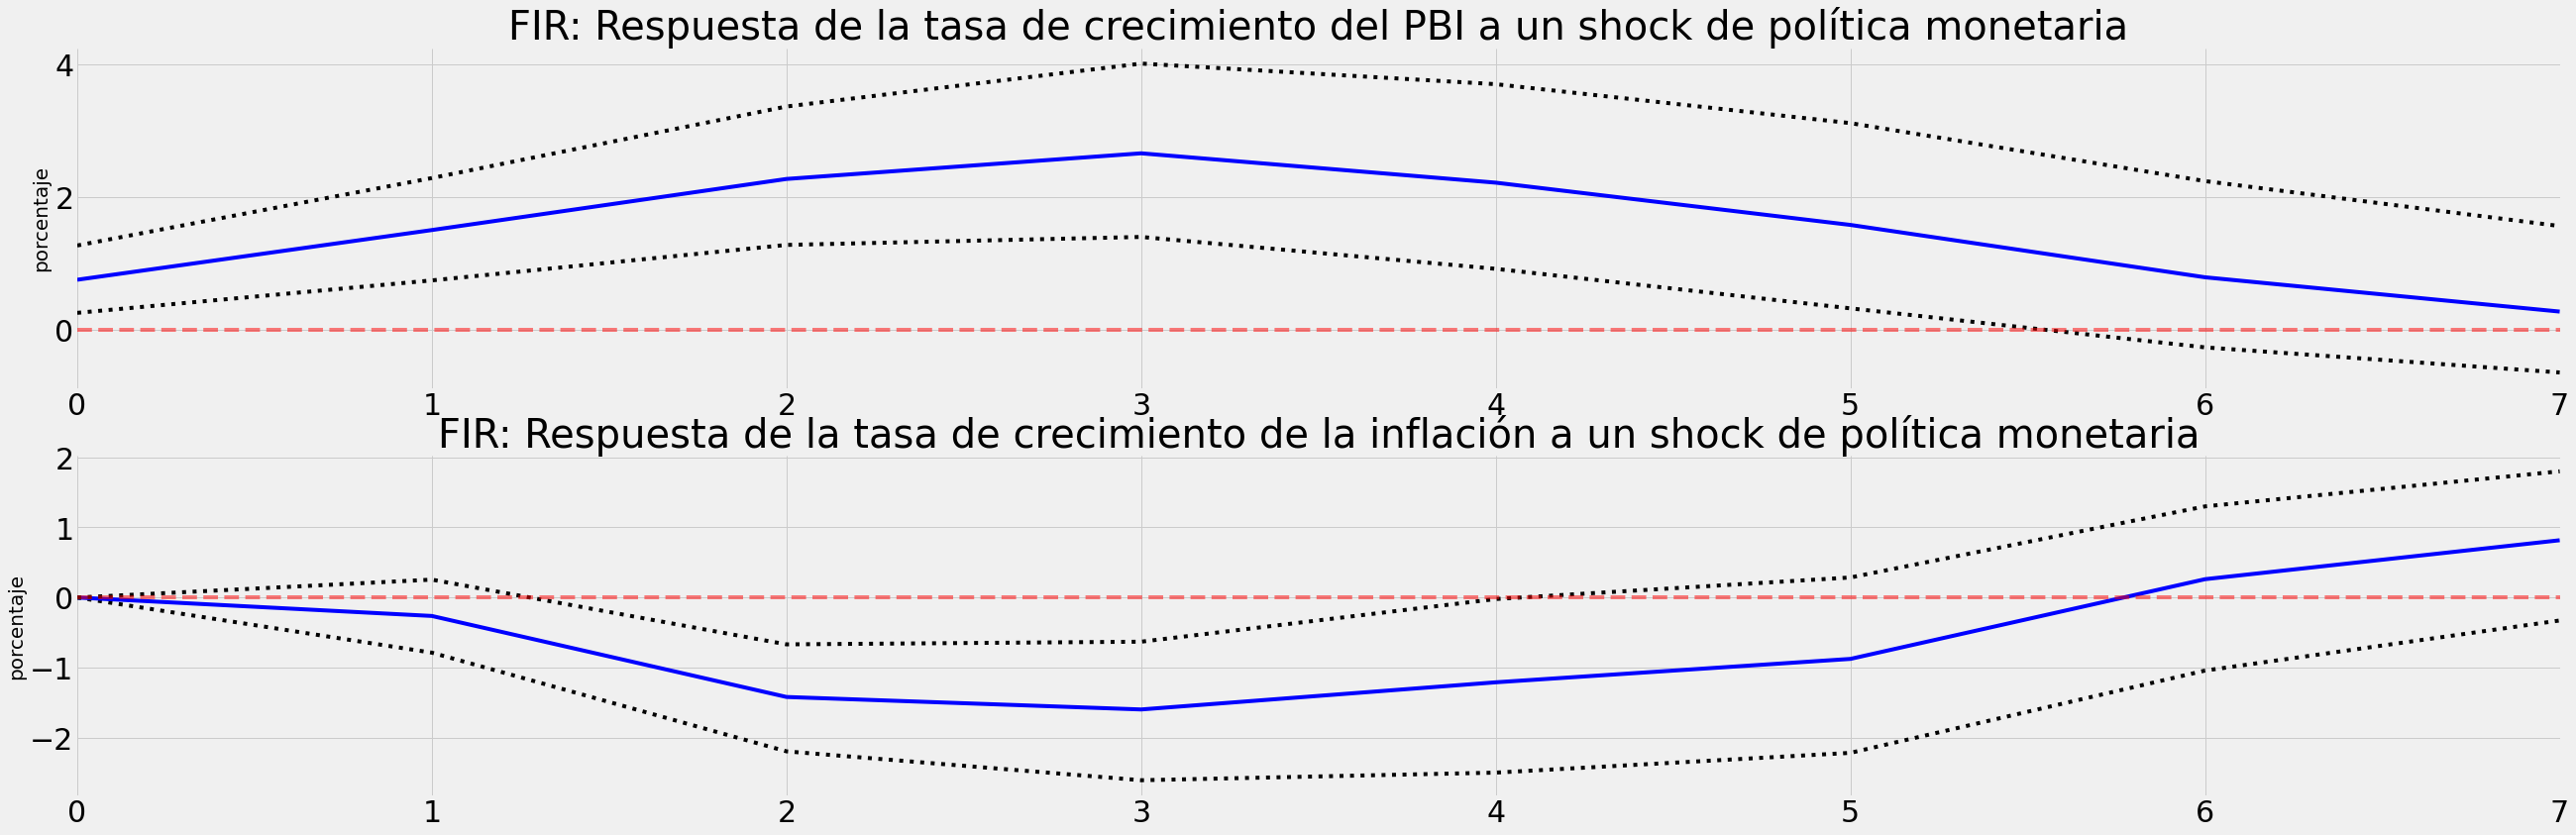

In [244]:

# Plots
fig = plt.figure(figsize=(40, 20))

ax1 = plt.subplot(3,1,1, frameon=False) 
ax1.plot(imp_pbi_quant[0,1,:],':k')
ax1.plot(imp_pbi_quant[1,1,:],'-b')
ax1.plot(imp_pbi_quant[2,1,:],':k')
plt.axhline(y=0.0,color='r',alpha=.5,linestyle='--')
ax1.set_title('FIR: Respuesta de la tasa de crecimiento del PBI a un shock de política monetaria', fontsize=40)
ax1.set_ylabel('porcentaje', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='x', tight=True)

ax1 = plt.subplot(3,1,2, frameon=False) 
ax1.plot(imp_inf_quant[0,1,:],':k')
ax1.plot(imp_inf_quant[1,1,:],'-b')
ax1.plot(imp_inf_quant[2,1,:],':k')
plt.axhline(y=0.0,color='r',alpha=.5,linestyle='--')
ax1.set_title('FIR: Respuesta de la tasa de crecimiento de la inflación a un shock de política monetaria', fontsize=40)
ax1.set_ylabel('porcentaje', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='x', tight=True)


Ahora $\Sigma_u$ aparece en la prior: 

$$\alpha|\Sigma_u \sim \mathcal{N}(\alpha^{*}, V \otimes \Sigma_u) $$

$$ \Sigma_u \sim \mathcal{IW}_K(S_{*}, n)$$

de tal forma que $\Sigma_u^{-1} \sim \mathcal{W}_K(S_{*}^{-1}, n)$. $V = \eta I$.

In [148]:
## --- CONSTRUCCIÓN DE LA PRIOR GAUSSIANA-WISHART INVERSA --- ##
p_eta=100 
# Primero creamos la media de la prior. Recuerden que el intercepto estará centrado en 0 (primer vector), 
# luego asumiremos que la media del primer rezago es 1 (random walk), eso quiere decir que tendremos 
# una matriz identidad KxK. Finalmente la media de los otros términos cruzados y rezagos estarán centrados en 0
# el tercer elemento del concatenar

# Parte 1: Prior de la Media en el VAR (si es ruido blanco = 0)
if random_walk:
    A_prior = np.concatenate( (np.concatenate( (np.zeros((1,K0)),np.eye(K0)) ),
                                np.zeros(((p_-1)*K0,K0)) ) )
    a_prior = A_prior.flatten('F')
else:
    A_prior = np.concatenate( (np.concatenate( (np.zeros((1,K0)),np.zeros((K0,K0))) ),
                                np.zeros(((p_-1)*K0,K0)) ) ) 
    a_prior = A_prior.flatten('F')

# Parte 2: Prior de la Varianza de la media en el VAR
V_prior = p_eta * np.eye(K1)


# Parte 3: Prior de la matriz de varianza en el VAR
v_prior     = K0 + 1                  # Grados de libertad
S_prior     = np.eye(K0)              # Grados de libertad
inv_S_prior = np.linalg.inv(S_prior)


Posterior de la varianza: $(V^{-1} + ZZ^{'})^{-1}\otimes \Sigma_u$. 

Posterior de la medida: $ \overline{A}= (A^{*}V^{-1}+YZ^{-1})(V^{-1}+ZZ')^{-1} $

Recordemos que $Z=  Z^{'}\otimes I_k = X\otimes I_k$ (o sea $Z'=X$). 

In [150]:
## --- MUESTREANDO DE LA DSITRIBUCIÓN POSTERIOR y FIR --- ##
st_time = time.time()

for i_rep in range(1,n_tot+1):
    if np.remainder(i_rep, disp_iter) ==0:
        print('Número de iteración: ', i_rep, 
              ' Tiempo en segundos: ', np.round(time.time()-st_time,3))
    
    # Construimos la varianza y media de la posterior de las matrices de rezagos
    V_post  = np.linalg.inv(np.linalg.inv(V_prior) + np.dot(X.T,X))
    A_post  = np.dot(V_post,np.dot(np.linalg.inv(V_prior),A_prior)+\
                                      np.dot(np.dot(X.T,X),A_MCO))
    a_post  = A_post.flatten('F')
    
    # Construimos los parametros de la distribucion de Wishart de la posterior
    S_post  = SSE_MCO + S_prior + np.dot(np.dot(A_MCO.T,np.dot(X.T,X)),A_MCO) +\
                np.dot(np.dot(A_prior.T,np.linalg.inv(V_prior)),A_prior) -\
                np.dot(np.dot(A_post.T,np.linalg.inv(V_prior)+np.dot(X.T,X)),A_post)
    v_post  = T1 + v_prior
    
    # Matriz de covarianza de la densidad de la posterior de alpha
    COV = np.kron(SIGMA_MCO,V_post)
    
    # Posterior de alpha|SIGMA,Data ~ N
    alpha = a_post + np.dot(np.linalg.cholesky(COV),np.random.randn(K0*K1))
    ALPHA = np.reshape(alpha, (K1, K0), order='F')
    
    # Posterior de SIGMA|SIGMA,Data ~ iW
    SIGMA = np.linalg.inv(Wish_dist(np.linalg.inv(S_post),v_post))
    
    if i_rep > n_burn:
        
        # Computo de las FIR
        if impulso:
            
            # Creamos las matrices de rezagos del VAR en forma reducida
            Av = np.zeros((K0,K0,p_))
            
            for i_1 in range(p_):
                Av[:,:,i_1] = ALPHA[1+(i_1*K0):(i_1+1)*K0+1,:].T
            
            # Usamos la decomposición recursiva (Cholesky)
            shock = np.linalg.cholesky(SIGMA).T
            
            # FIR
            responses = FIR_bis(Av,shock,imp_h)
            
            # FIR for each shock
            responses1 = responses[:,0,:]
            responses2 = responses[:,1,:]
            responses3 = responses[:,2,:]
            
            imp_pbi[i_rep-n_burn-1,:,:] = responses1
            imp_mon[i_rep-n_burn-1,:,:] = responses2
            imp_inf[i_rep-n_burn-1,:,:] = responses3
        
        # Guardar cada muestreo de los parámetros
        alpha_draws[i_rep-n_burn-1,:] = alpha
        ALPHA_draws[i_rep-n_burn-1,:] = ALPHA
        SIGMA_draws[i_rep-n_burn-1,:] = SIGMA

        
# Media de la posterior de los parámetros
ALPHA_mean = np.mean(ALPHA_draws,axis=0)
SIGMA_mean = np.mean(SIGMA_draws,axis=0)

# Desviación estándar de la posterior de los parámetros
ALPHA_std = np.std(ALPHA_draws,axis=0)
SIGMA_std = np.std(SIGMA_draws,axis=0)

# Quantiles de la posterio
quant_        = [.1, .5, .9]
imp_pbi_quant = np.quantile(imp_pbi,quant_,axis=0)
imp_mon_quant = np.quantile(imp_mon,quant_,axis=0)
imp_inf_quant = np.quantile(imp_inf,quant_,axis=0)


Número de iteración:  2000  Tiempo en segundos:  0.785
Número de iteración:  4000  Tiempo en segundos:  1.521
Número de iteración:  6000  Tiempo en segundos:  2.278
Número de iteración:  8000  Tiempo en segundos:  3.057
Número de iteración:  10000  Tiempo en segundos:  3.794


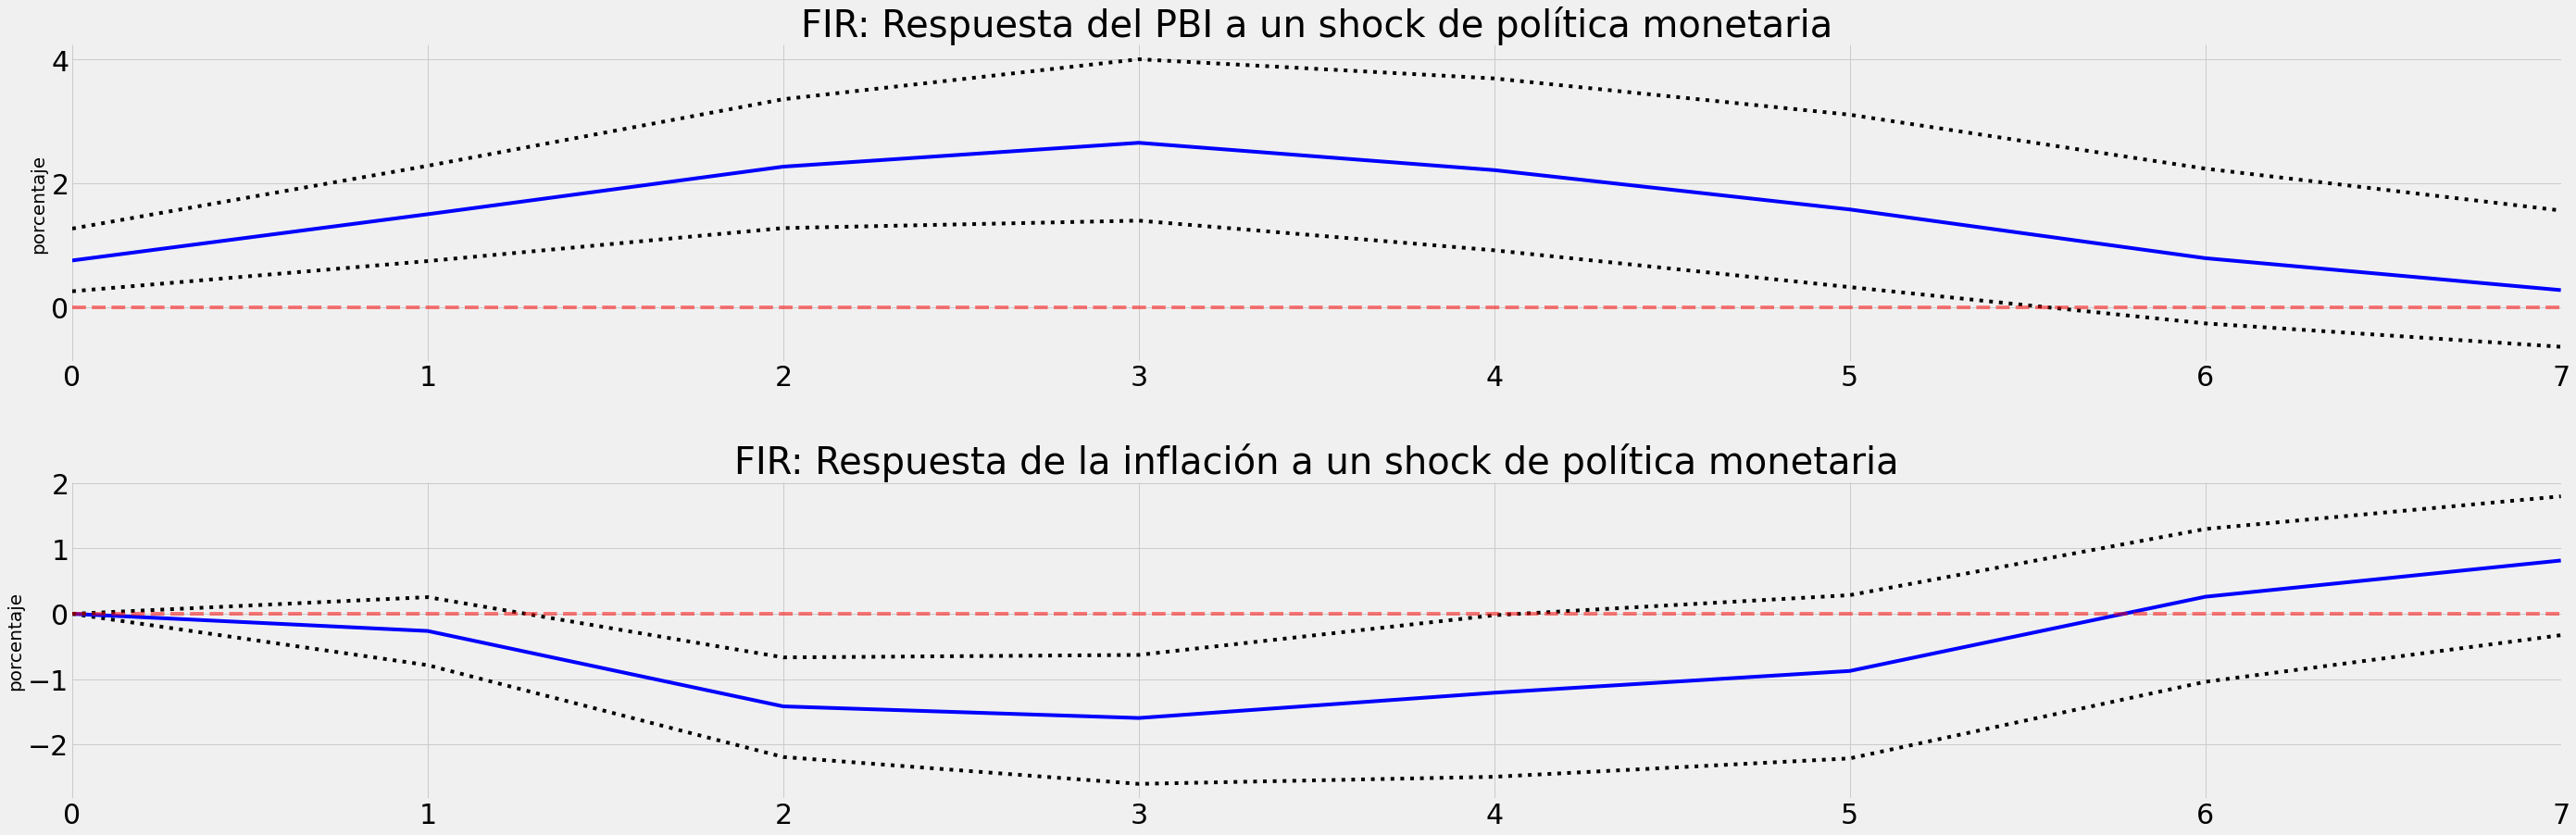

In [152]:
## --- GRÁFICOS DE LAS FIR PARA CADA UNA DE LAS VARIABLES A UN SHOCK DE POLÍTICA MONETARIA --- ##

# Plots
fig = plt.figure(figsize=(40, 20))

ax1 = plt.subplot(3,1,1, frameon=False) 
ax1.plot(imp_pbi_quant[0,1,:],':k')
ax1.plot(imp_pbi_quant[1,1,:],'-b')
ax1.plot(imp_pbi_quant[2,1,:],':k')
plt.axhline(y=0.0,color='r',alpha=.5,linestyle='--')
ax1.set_title('FIR: Respuesta del PBI a un shock de política monetaria', fontsize=40)
ax1.set_ylabel('porcentaje', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='x', tight=True)
#ax1.set_ylim([-0.25, 0.3])

ax1 = plt.subplot(3,1,2, frameon=False) 
ax1.plot(imp_inf_quant[0,1,:],':k')
ax1.plot(imp_inf_quant[1,1,:],'-b')
ax1.plot(imp_inf_quant[2,1,:],':k')
plt.axhline(y=0.0,color='r',alpha=.5,linestyle='--')
ax1.set_title('FIR: Respuesta de la inflación a un shock de política monetaria', fontsize=40)
ax1.set_ylabel('porcentaje', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='x', tight=True)
#ax1.set_ylim([-0.25, 0.3])


fig.tight_layout(pad=4.0)

## Independent Gaussian-inverse Wishart

In [144]:
## --- CONSTRUCCIÓN DE LA PRIOR GAUSSIANA-WISHART INVERSA INDEPENDIENTE --- ##

# Primero creamos la media de la prior. Recuerden que el intercepto estará centrado en 0 (primer vector), 
# luego asumiremos que la media del primer rezago es 1 (random walk), eso quiere decir que tendremos 
# una matriz identidad KxK. Finalmente la media de los otros términos cruzados y rezagos estarán centrados en 0
# el tercer elemento del concatenar

# Parte 1: Prior de la Media en el VAR
if random_walk:
    A_prior = np.concatenate( (np.concatenate( (np.zeros((1,K0)),np.eye(K0)) ),
                                np.zeros(((p_-1)*K0,K0)) ) )
    a_prior = A_prior.flatten('F')
else:
    A_prior = np.concatenate( (np.concatenate( (np.zeros((1,K0)),np.zeros((K0,K0))) ),
                                np.zeros(((p_-1)*K0,K0)) ) ) 
    a_prior = A_prior.flatten('F')

# Parte 2: Prior de la Varianza de la media en el VAR
V_prior = p_eta * np.eye(K0*K1)


# Parte 3: Prior de la matriz de varianza en el VAR
v_prior     = K0 + 1                  # Grados de libertad
S_prior     = np.eye(K0)              # Grados de libertad
inv_S_prior = np.linalg.inv(S_prior)

In [86]:
## --- MUESTREANDO DE LA DSITRIBUCIÓN POSTERIOR y FIR --- ##
st_time = time.time()

for i_rep in range(1,n_tot+1):
    if np.remainder(i_rep, disp_iter) ==0:
        print('Número de iteración: ', i_rep, 
              ' Tiempo en segundos: ', np.round(time.time()-st_time,3))
    
    # Posterior for Alpha from Gaussian distribution
    Variance = np.kron(np.linalg.inv(SIGMA_MCO),np.eye(T1))
    V_post   = np.linalg.inv(np.linalg.inv(V_prior)+np.dot(np.dot(Z.T,Variance),Z))
    a_post   = np.dot(V_post, np.dot(np.linalg.inv(V_prior),a_prior) +\
                np.dot(np.dot(Z.T,Variance),np.reshape(Y, (T1*K0), order='F')))
    
    alpha    = a_post + np.dot(np.linalg.cholesky(V_post),np.random.randn(K0*K1))
    ALPHA    = np.reshape(alpha, (K1, K0), order='F') 
    
    # Posterior for SIGMA
    v_post  = T1 + v_prior
    S_post  = SSE_MCO + np.dot((Y - np.dot(X,ALPHA)).T,(Y - np.dot(X,ALPHA)))
    SIGMA   = np.linalg.inv(Wish_dist(np.linalg.inv(S_post),v_post))
    
    if i_rep > n_burn:
        
        # Computo de las FIR
        if impulso:
            
            # Creamos las matrices de rezagos del VAR en forma reducida
            Av = np.zeros((K0,K0,p_))
            
            for i_1 in range(p_):
                Av[:,:,i_1] = ALPHA[1+(i_1*K0):(i_1+1)*K0+1,:].T
            
            # Usamos la decomposición recursiva (Cholesky)
            shock = np.linalg.cholesky(SIGMA).T
            
            # FIR
            responses = FIR_bis(Av,shock,imp_h)
            
            # FIR for each shock
            responses1 = responses[:,0,:]
            responses2 = responses[:,1,:]
            responses3 = responses[:,2,:]
            
            imp_pbi[i_rep-n_burn-1,:,:] = responses1
            imp_mon[i_rep-n_burn-1,:,:] = responses2
            imp_inf[i_rep-n_burn-1,:,:] = responses3
        
        # Guardar cada muestreo de los parámetros
        alpha_draws[i_rep-n_burn-1,:] = alpha
        ALPHA_draws[i_rep-n_burn-1,:] = ALPHA
        SIGMA_draws[i_rep-n_burn-1,:] = SIGMA

        
# Media de la posterior de los parámetros
ALPHA_mean = np.mean(ALPHA_draws,axis=0)
SIGMA_mean = np.mean(SIGMA_draws,axis=0)

# Desviación estándar de la posterior de los parámetros
ALPHA_std = np.std(ALPHA_draws,axis=0)
SIGMA_std = np.std(SIGMA_draws,axis=0)

# Quantiles de la posterio
quant_        = [.1, .5, .9]
imp_pbi_quant = np.quantile(imp_pbi,quant_,axis=0)
imp_mon_quant = np.quantile(imp_mon,quant_,axis=0)
imp_inf_quant = np.quantile(imp_inf,quant_,axis=0)


Número de iteración:  2000  Tiempo en segundos:  1.299
Número de iteración:  4000  Tiempo en segundos:  2.575
Número de iteración:  6000  Tiempo en segundos:  3.899
Número de iteración:  8000  Tiempo en segundos:  5.265
Número de iteración:  10000  Tiempo en segundos:  6.662


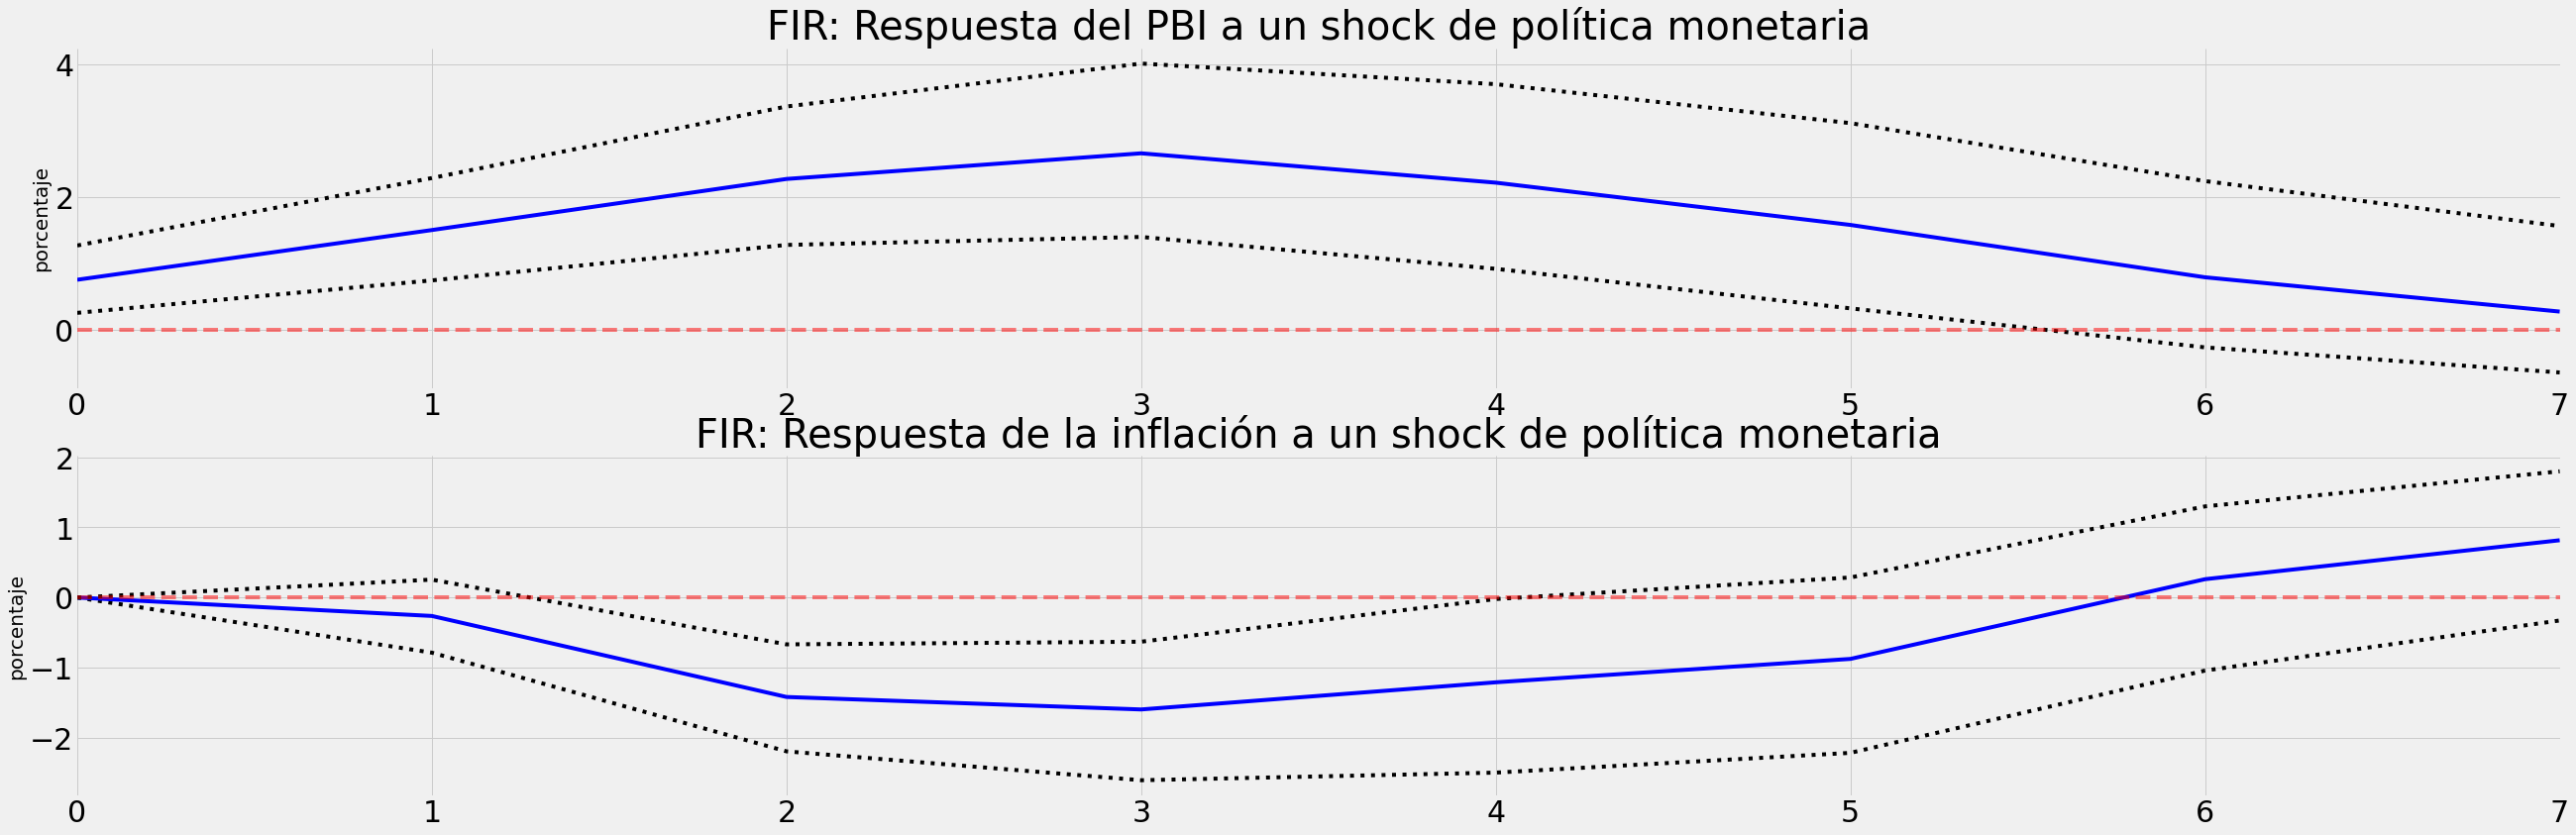

In [157]:
## --- GRÁFICOS DE LAS FIR PARA CADA UNA DE LAS VARIABLES A UN SHOCK DE POLÍTICA MONETARIA --- ##

# Plots
fig = plt.figure(figsize=(40, 20))

ax1 = plt.subplot(3,1,1, frameon=False) 
ax1.plot(imp_pbi_quant[0,1,:],':k')
ax1.plot(imp_pbi_quant[1,1,:],'-b')
ax1.plot(imp_pbi_quant[2,1,:],':k')
plt.axhline(y=0.0,color='r',alpha=.5,linestyle='--')
ax1.set_title('FIR: Respuesta del PBI a un shock de política monetaria', fontsize=40)
ax1.set_ylabel('porcentaje', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='x', tight=True)


ax1 = plt.subplot(3,1,2, frameon=False) 
ax1.plot(imp_inf_quant[0,1,:],':k')
ax1.plot(imp_inf_quant[1,1,:],'-b')
ax1.plot(imp_inf_quant[2,1,:],':k')
plt.axhline(y=0.0,color='r',alpha=.5,linestyle='--')
ax1.set_title('FIR: Respuesta de la inflación a un shock de política monetaria', fontsize=40)
ax1.set_ylabel('porcentaje', fontsize=20)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.autoscale(enable=True, axis='x', tight=True)

Se observa que, para cada simulación (para cada prior), la FIR para: PBI - shock de política monetaria y Tasa de Inflación (var%) - shock de política monetaria, son similares. Se anticipa una subida gradual y luego desaceleración en cuanto al PBI, y para la inflación una caída gradual y luego abrupta, que termina en una subida en el periodo final. 


Análisis de variación de parámertros (incremento) $\lambda, \theta$ y $\eta$: enanchamiento de bandas de confianza (coherente con el significado de $\lambda$), caídas o subidas menos abruptas.


Notemos que, imp_variable_quant[0,x,:] nos indica que justamente simulamos un shock de política monetaria: $x=1$. Acá variable es pbi o inflación. 

# Pregunta 3

En esta pregunta se le pide estimar un modelo de factores dinámicos usando los datos mensuales para la economia de EEUU en la base de datos FRED-MD; de igual forma, considerar el crecimiento del PBI cuya frecuencia es trimestral y se encuentra en FRED-QD.  Estimar el modelo con dos factores globales y un factor especifico para cada grupo de variables. Para el caso de los factores globales considerar 4 rezagos y para los factores específicos 1 rezago. Se le pide lo siguiente:

    1. Graficar los factores globales e ideosincráticos (ambos smoothed).
    2. Graficar el R^2 ndividual de cada uno de los factores.
    3. Generar una predicción para la tasa de crecimiento del PBI y la tasa de desempleo.
    4. Finalmente hacer un ejercicio de nowcast para el PBI del 2020 con los vintages de Febrero 2020, luego actualizar la    predicción con los datos de Marzo 2020, Abril 2020, Mayo 2020, Junio 2020.


Tomamos como referencia: https://www.chadfulton.com/topics/statespace_large_dynamic_factor_models.html#references


El modelo de factores dinámicos es

$$
\begin{aligned}
y_t & = \Lambda f_t + \epsilon_t \\
f_t & = A_1 f_{t-1} + \dots + A_p f_{t-p} + u_t
\end{aligned}
$$

Los DFM buscan analizar la evolución de un vector de $N$ series de tiempo $\{X_{it}\}_{1 \leq i \leq N}$ usando un número reducido de factores comunes no observables $\{f_t\}$.

In [169]:
#En la carpeta donde se ubica su archivo, crear las carpetas MD y QD, y almacenar en cada una los archivos 
# '2020-02', '2020-03', '2020-04', '2020-05', '2020-06' decargables en 
#https://research.stlouisfed.org/econ/mccracken/fred-databases/

dta = {date: load_fredmd_data(date)
       for date in ['2020-02', '2020-03', '2020-04', '2020-05', '2020-06']}

In [170]:
dta

{'2020-02': namespace(orig_m=               RPI  W875RX1  DPCERA3M086SBEA     CMRMTSPLx       RETAILx  \
                  1959-01   2437.296   2288.8           17.302  2.922588e+05   18235.77392   
                  1959-02   2446.902   2297.0           17.482  2.944295e+05   18369.56308   
                  1959-03   2462.689   2314.0           17.647  2.934254e+05   18523.05762   
                  1959-04   2478.744   2330.3           17.584  2.993317e+05   18534.46600   
                  1959-05   2493.228   2345.8           17.796  3.013730e+05   18679.66354   
                  ...            ...      ...              ...           ...           ...   
                  2019-09  17036.522  14120.7          121.554  1.524004e+06  524651.00000   
                  2019-10  17025.707  14105.5          121.605  1.516833e+06  526420.00000   
                  2019-11  17089.328  14168.5          121.881  1.525004e+06  527518.00000   
                  2019-12  17072.122  14157.4    

##  Graficamos los factores globales e ideosincráticos (ambos smoothed)

In [172]:
# summary de la data baja de Fulton
# https://github.com/ChadFulton/tsa-notebooks/tree/0bd5ef7acb07dac5f3432a1fa748a4469753804b/data
defn_m = pd.read_csv('fredmd_definitions.csv')
defn_m.index = defn_m.fred
defn_q = pd.read_csv('fredqd_definitions.csv')
defn_q.index = defn_q.fred

defn_m.head()

group  id  tcode     fred  \
fred                                             
RPI      Output and Income   1      5      RPI   
W875RX1  Output and Income   2      5  W875RX1   
INDPRO   Output and Income   6      5   INDPRO   
IPFPNSS  Output and Income   7      5  IPFPNSS   
IPFINAL  Output and Income   8      5  IPFINAL   

                                           description          gsi  \
fred                                                                  
RPI                               Real Personal Income   M_14386177   
W875RX1      Real personal income ex transfer receipts  M_145256755   
INDPRO                                        IP Index  M_116460980   
IPFPNSS  IP: Final Products and Nonindustrial Supplies  M_116460981   
IPFINAL              IP: Final Products (Market Group)  M_116461268   

           gsi:description  asterisk  
fred                                  
RPI                     PI       NaN  
W875RX1  PI less transfers       NaN  
INDPRO           IP: total       NaN  
IPFPNSS       IP: products       NaN  
IPFINAL     IP: final prod       NaN

In [175]:
# Remplazar los nombres 
map_m = defn_m['description'].to_dict()
map_q = defn_q['description'].to_dict()
for date, value in dta.items():
    value.orig_m.columns = value.orig_m.columns.map(map_m)
    value.dta_m.columns = value.dta_m.columns.map(map_m)
    value.orig_q.columns = value.orig_q.columns.map(map_q)
    value.dta_q.columns = value.dta_q.columns.map(map_q)

In [176]:
# id --> grupo
groups = defn_m[['description', 'group']].copy()

# Re-orderdenas en funcion del CSV

columns = [name for name in defn_m['description']
           if name in dta['2020-02'].dta_m.columns]
for date in dta.keys():
    dta[date].dta_m = dta[date].dta_m.reindex(columns, axis=1)

#GDP a output-income
gdp_description = defn_q.loc['GDPC1', 'description']
groups = groups.append({'description': gdp_description, 'group': 'Output and Income'},
                       ignore_index=True)

# NUMERO DE var por grupo
(groups.groupby('group', sort=False)
       .count()
       .rename({'description': '# series in group'}, axis=1))

# series in group
group                                                  
Output and Income                                    18
Labor Market                                         32
Housing                                              10
Consumption, orders, and inventories                 14
Money and credit                                     14
Interest and exchange rates                          22
Prices                                               21
Stock market                                          5

Recordemos que en los modelos de factores latentes existen 3 elementos importantes: 

- normalizar las variables
- especificiar factores
- errores como AR(1) o iid($\mu$, $\sigma^2$)


Se decide usar, en cuanto a la especificacion de factores, VAR(4) para 2 factores globales, y AR(1) para factores especificos a un grupo. 

$$\varepsilon_t = \rho\varepsilon_{t-1}+u_t$$


In [192]:

factors = {row['description']: ['Global', row['group']]
           for ix, row in groups.iterrows()}

print(factors['Real Personal Income'])

#2 factores globales
factor_multiplicities = {'Global': 2}

# var 4
factor_orders = {'Global': 4}

['Global', 'Output and Income']


In [179]:
start = '2000'
endog_m = dta['2020-02'].dta_m.loc[start:, :]
gdp_description = defn_q.loc['GDPC1', 'description']
endog_q = dta['2020-02'].dta_q.loc[start:, [gdp_description]]

model = sm.tsa.DynamicFactorMQ(
    endog_m, endog_quarterly=endog_q,
    factors=factors, factor_orders=factor_orders,
    factor_multiplicities=factor_multiplicities)

In [180]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                          
============================================================================================
Model:                 Dynamic Factor Model   # of monthly variables:                    128
                   + 10 factors in 9 blocks   # of quarterly variables:                    1
                    + Mixed frequency (M/Q)   # of factor blocks:                          9
                      + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                             2000-01   Standardize variables:                    True
                                  - 2020-01                                                 
                                                                                 Observed variables / factor loadings                                                                                 
======================================================================================================================================================================================================
              Dep. variable   Global.1   Global.2 Output and Income Labor Market     Housing Consumption, orders, and inventories Money and credit Interest and exchange rates     Prices Stock market
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
       Real Personal Income      X          X             X                                                                                                                                           
Real personal income ex ...      X          X             X                                                                                                                                           
                   IP Index      X          X             X                                                                                                                                           
IP: Final Products and N...      X          X             X                                                                                                                                           
IP: Final Products (Mark...      X          X             X                                                                                                                                           
         IP: Consumer Goods      X          X             X                                                                                                                                           
IP: Durable Consumer Goo...      X          X             X                                                                                                                                           
IP: Nondurable Consumer ...      X          X             X                                                                                                                                           
     IP: Business Equipment      X          X             X                                                                                                                                           
              IP: Materials      X          X             X                                                                                                                                           
      IP: Durable Materials      X          X             X                                                                                                                                           
   IP: Nondurable Materials      X          X             X                                                                                                                                           
    IP: Manufacturing (S

Diferencia Globales y grupales:

$$X_1 = \lambda_{11}f_1 + \lambda_{12}f_2 + \alpha \tilde{f}  + 0 \hat{f}$$

$$X_2 = \lambda_{11}f_1 + \lambda_{12}f_2 + 0 \tilde{f}  + \beta \hat{f}$$

In [181]:
results = model.fit(disp=10)

EM start iterations, llf=-28556
EM iteration 10, llf=-25703, convergence criterion=0.00045107
EM iteration 20, llf=-25673, convergence criterion=3.1194e-05
EM iteration 30, llf=-25669, convergence criterion=8.8719e-06
EM iteration 40, llf=-25668, convergence criterion=3.7567e-06
EM iteration 50, llf=-25667, convergence criterion=2.0379e-06
EM iteration 60, llf=-25667, convergence criterion=1.3147e-06
EM converged at iteration 69, llf=-25666, convergence criterion=9.7195e-07 < tolerance=1e-06


El algoritmo de EM funciona de la siguienta manera: dado un modelo que genera un conjunto de data observable $\textbf{X}$ y un conjunto de data latente no observada $\textbf{Z}$, y un vector de parámetros $\theta$, en conjunto a la función de verosimilitud $L(\theta; X, Z) = p(X, Z|\theta)$, buscamos 

$$
\theta \in \text{argmax}\left\{ L(\theta; X) = p(X|\theta) = \int p(X, Z|\theta)dZ = \int p(X|Z, \theta)p(Z|\theta)dZ \right\}
$$

Dado que $p(Z|\theta)$  es complicado de medir, se emplea el siguiente algoritmo (EM)

- Definamos $Q(\theta|\theta^{(t)})$ como el valor esperado de $L(\theta; X)$ y la estimación actual de los parámetros $\theta^{(t)}$. 

$$Q(\theta|\theta^{(t)}) = \mathbb{E}_{Z|X, \theta^{(t)}}[\ln L(\theta; X, Z)]$$

Se busca $\theta^{(t+1)} \in \text{argmax}_{\theta}Q(\theta|\theta^{(t)})$. Se repite siendo $t$ el paso hasta cierto punto, establecido por criterio previos.


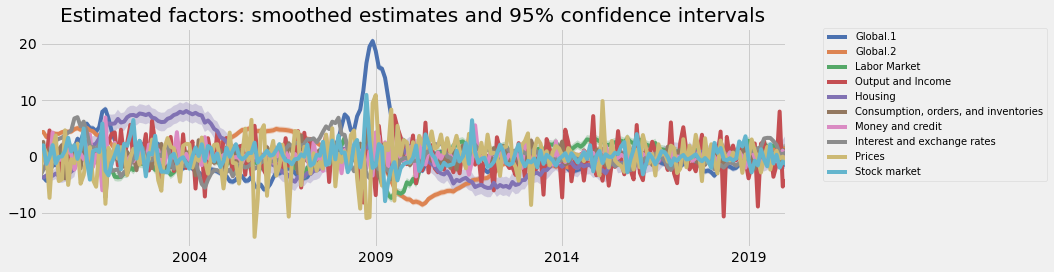

In [191]:
#smoothed
factor_names = ['Global.1', 'Global.2', 'Labor Market', 'Output and Income', 'Housing', 'Consumption, orders, and inventories'
               , 'Money and credit', 'Interest and exchange rates', 'Prices', 'Stock market']
mean = results.factors.smoothed[factor_names]

# 95% IC
from scipy.stats import norm
std = pd.concat([results.factors.smoothed_cov.loc[name, name]
                 for name in factor_names], axis=1)
crit = norm.ppf(1 - 0.05 / 2)
lower = mean - crit * std
upper = mean + crit * std

with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(15, 4))
    mean.plot(ax=ax)
    
    for name in factor_names:
        ax.fill_between(mean.index, lower[name], upper[name], alpha=0.3)
    
    ax.set(title='Estimated factors: smoothed estimates and 95% confidence intervals')
    ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # put legend to the right

    fig.tight_layout();

## Graficar el R^2 individual de cada uno de los factores

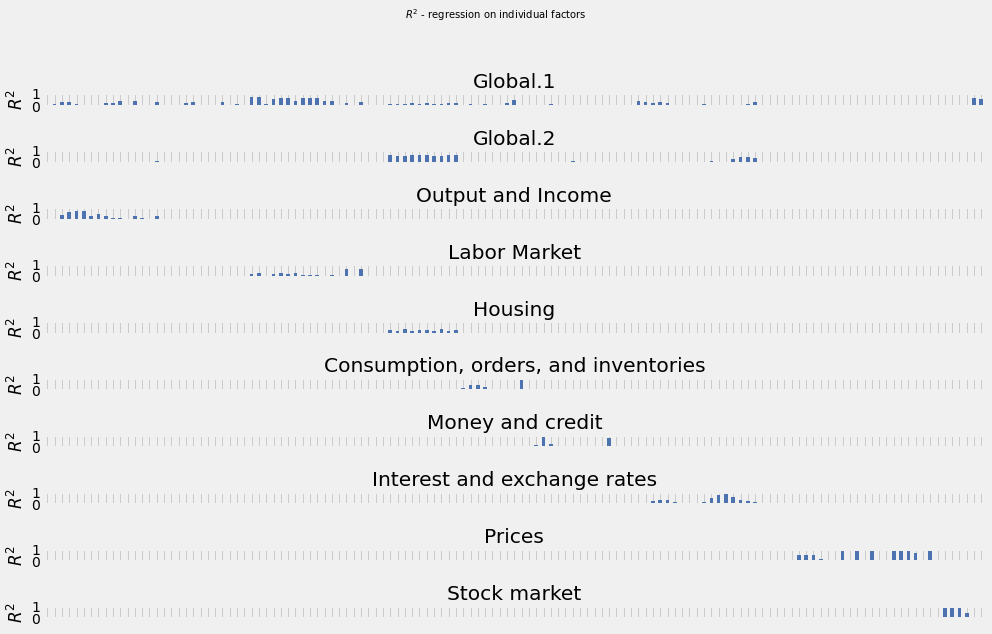

In [195]:
with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='individual', figsize=(14, 9))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=10, fontweight=500)
    fig.tight_layout(rect=[0, 0, 1, 0.95]);

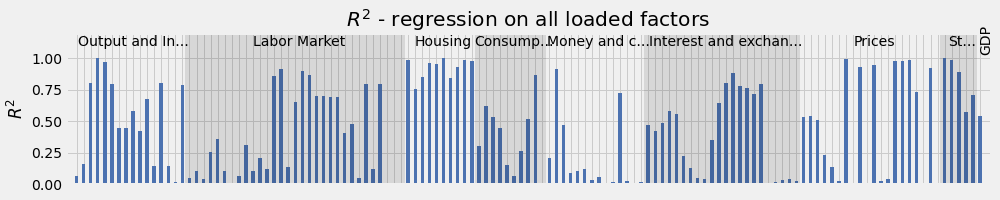

In [196]:
group_counts = defn_m[['description', 'group']]
group_counts = group_counts[group_counts['description'].isin(dta['2020-02'].dta_m.columns)]
group_counts = group_counts.groupby('group', sort=False).count()['description'].cumsum()

with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='joint', figsize=(14, 3));

    # Add in group labels
    ax = fig.axes[0]
    ax.set_ylim(0, 1.2)
    for i in np.arange(1, len(group_counts), 2):
        start = 0 if i == 0 else group_counts[i - 1]
        end = group_counts[i] + 1
        ax.fill_between(np.arange(start, end) - 0.6, 0, 1.2, color='k', alpha=0.1)
    for i in range(len(group_counts)):
        start = 0 if i == 0 else group_counts[i - 1]
        end = group_counts[i]
        n = end - start
        text = group_counts.index[i]
        if len(text) > n:
            text = text[:n - 3] + '...'

        ax.annotate(text, (start + n / 2, 1.1), ha='center')

    # Add label for GDP
    ax.set_xlim(-1.5, model.k_endog + 0.5)
    ax.annotate('GDP', (model.k_endog - 1.1, 1.05), ha='left', rotation=90)

    fig.tight_layout();

## Generar una predicción para la tasa de crecimiento del PBI y la tasa de desempleo

## Forecast


In [197]:
# 3 periodos adelante
point_forecasts = results.forecast(steps=3)

print(point_forecasts.T.head())

                                                2020-02   2020-03   2020-04
Real Personal Income                           0.220708  0.271456  0.257587
Real personal income ex transfer receipts      0.232887  0.270109  0.255253
IP Index                                       0.251309  0.156593  0.161717
IP: Final Products and Nonindustrial Supplies  0.274381  0.113899  0.134390
IP: Final Products (Market Group)              0.279685  0.097909  0.128986


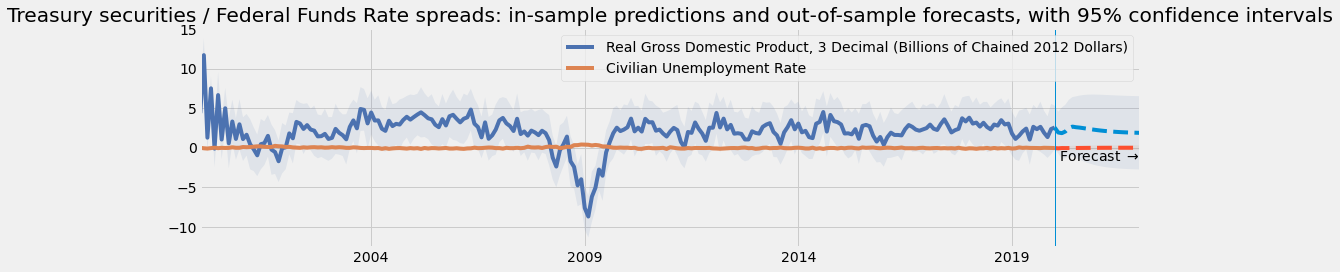

In [200]:
# Create forecasts results objects, through the end of 20201
prediction_results = results.get_prediction(start='2000', end='2022')

variables = ['Real Gross Domestic Product, 3 Decimal (Billions of Chained 2012 Dollars)', 
             'Civilian Unemployment Rate']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:'2020-01'].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc['2020-01':].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines('2020-01', ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', ('2020-01', -1.7))
    ax.set(title=('Treasury securities / Federal Funds Rate spreads:'
                  ' in-sample predictions and out-of-sample forecasts, with 95% confidence intervals'), ylim=ylim)
    
    fig.tight_layout()

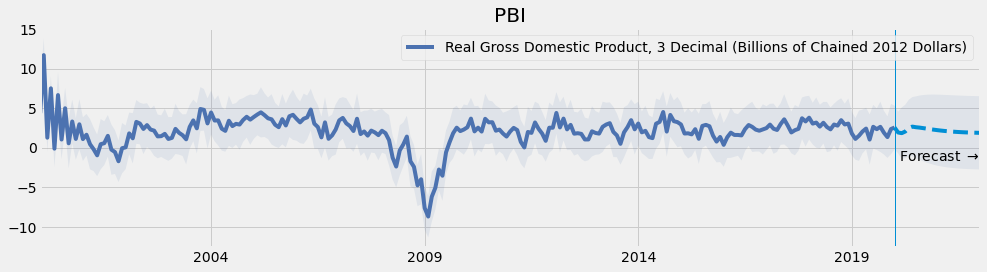

In [201]:
# Create forecasts results objects, through the end of 20201
prediction_results = results.get_prediction(start='2000', end='2022')

variables = ['Real Gross Domestic Product, 3 Decimal (Billions of Chained 2012 Dollars)']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:'2020-01'].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc['2020-01':].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines('2020-01', ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', ('2020-01', -1.7))
    ax.set(title=('PBI'), ylim=ylim)
    
    fig.tight_layout()

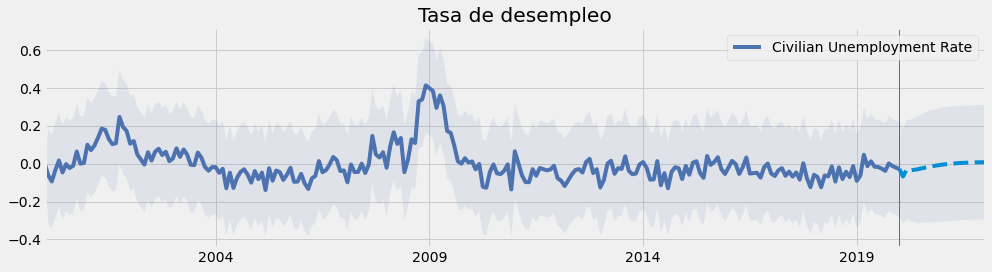

In [202]:
# Create forecasts results objects, through the end of 20201
prediction_results = results.get_prediction(start='2000', end='2022')

variables = [ 'Civilian Unemployment Rate']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:'2020-01'].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc['2020-01':].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines('2020-01', ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', ('2020-01', -1.7))
    ax.set(title=('Tasa de desempleo'), ylim=ylim)
    
    fig.tight_layout()

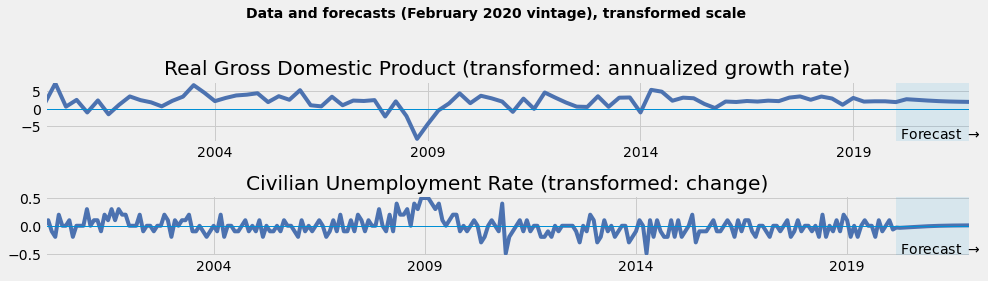

In [203]:
# variables 
unemp_description = 'Civilian Unemployment Rate'
gdp_description = 'Real Gross Domestic Product, 3 Decimal (Billions of Chained 2012 Dollars)'

# forecast
fcast_m = results.forecast('2021-12')[unemp_description]
fcast_q = results.forecast('2021-12')[gdp_description].resample('Q').last()


# combina data observada con forecast
plot_m = pd.concat([dta['2020-02'].dta_m.loc['2000':, unemp_description], fcast_m])
plot_q = pd.concat([dta['2020-02'].dta_q.loc['2000':, gdp_description], fcast_q])

with sns.color_palette('deep'):
    fig, axes = plt.subplots(2, figsize=(14, 4))

    # GDP
    plot_q.plot(ax=axes[0])
    axes[0].set(title='Real Gross Domestic Product (transformed: annualized growth rate)')
    axes[0].hlines(0, plot_q.index[0], plot_q.index[-1], linewidth=1)

    # Unemployment
    plot_m.plot(ax=axes[1])
    axes[1].set(title='Civilian Unemployment Rate (transformed: change)')
    axes[1].hlines(0, plot_m.index[0], plot_m.index[-1], linewidth=1)
    
 
    for i in range(2):
        ylim = axes[i].get_ylim()
        axes[i].fill_between(plot_q.loc['2020-02':].index,
                             ylim[0], ylim[1], alpha=0.1, color='C0')
        axes[i].annotate(r' Forecast $\rightarrow$',
                         ('2020-03', ylim[0] + 0.1 * ylim[1]))
        axes[i].set_ylim(ylim)


    fig.suptitle('Data and forecasts (February 2020 vintage), transformed scale',
                 fontsize=14, fontweight=600)

    fig.tight_layout(rect=[0, 0, 1, 0.95]);

## Finalmente hacer un ejercicio de nowcast para el PBI del 2020 con los vintages de Febrero 2020, luego actualizar la predicción con los datos de Marzo 2020, Abril 2020, Mayo 2020, Junio 2020

In [204]:
# Febrero 2020
vintage_results = {'2020-02': results}

# Dataset mensuales y trimestrales
start = '2000'
updated_endog_m = dta['2020-03'].dta_m.loc[start:, :]
gdp_description = defn_q.loc['GDPC1', 'description']
updated_endog_q = dta['2020-03'].dta_q.loc[start:, [gdp_description]]

# Marzo
vintage_results['2020-03'] = results.apply(
    updated_endog_m, endog_quarterly=updated_endog_q)


updated_forecasts_q = (
    vintage_results['2020-03'].forecast('June 2020')[gdp_description]
                              .resample('Q').last())

print('March 2020 forecast for real GDP growth in 2020Q2:'
      f' {updated_forecasts_q["2020Q2"]:.2f}%')

# abril mayo y junio
for vintage in ['2020-04', '2020-05', '2020-06']:

    updated_endog_m = dta[vintage].dta_m.loc[start:, :]
    updated_endog_q = dta[vintage].dta_q.loc[start:, [gdp_description]]

    vintage_results[vintage] = results.apply(
        updated_endog_m, endog_quarterly=updated_endog_q)
    
forecasts = {vintage: res.forecast('June 2020')[gdp_description]
                         .resample('Q').last().loc['2020Q2']
             for vintage, res in vintage_results.items()}
#formato pandas
forecasts = pd.Series(list(forecasts.values()),
                      index=pd.PeriodIndex(forecasts.keys(), freq='M'))
    
for vintage, value in forecasts.items():
    print(f'{vintage} forecast for real GDP growth in 2020Q2:'
          f' {value:.2f}%')

March 2020 forecast for real GDP growth in 2020Q2: 2.52%
2020-02 forecast for real GDP growth in 2020Q2: 2.68%
2020-03 forecast for real GDP growth in 2020Q2: 2.52%
2020-04 forecast for real GDP growth in 2020Q2: -8.23%
2020-05 forecast for real GDP growth in 2020Q2: -37.17%
2020-06 forecast for real GDP growth in 2020Q2: -22.33%


Notar que esto se debe a la Pandemia de la COVID 19. De manera gráfica (para el trimestre 2). 

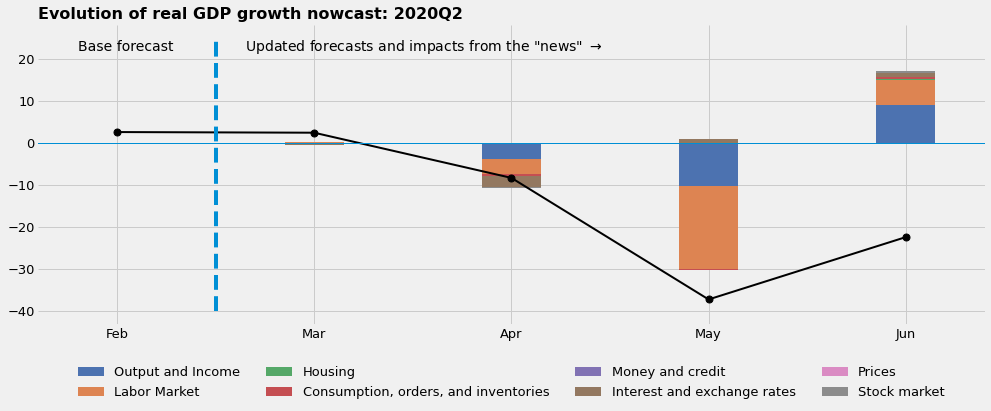

In [206]:
news = vintage_results['2020-04'].news(
    vintage_results['2020-03'], impact_date='2020-06',
    impacted_variable=gdp_description,
    comparison_type='previous')

details = news.details_by_impact
details.index = details.index.droplevel(['impact date', 'impacted variable'])
details['absolute impact'] = np.abs(details['impact'])
details = (details.sort_values('absolute impact', ascending=False)
                  .drop('absolute impact', axis=1))
details.iloc[:10].round(2)


news_results = {}
vintages = ['2020-02', '2020-03', '2020-04', '2020-05', '2020-06']
impact_date = '2020-06'

for i in range(1, len(vintages)):
    vintage = vintages[i]
    prev_vintage = vintages[i - 1]

    # Notice that to get the "incremental" news, we are computing
    # the news relative to the previous vintage and not to the baseline
    # (February 2020) vintage
    news_results[vintage] = vintage_results[vintage].news(
        vintage_results[prev_vintage],
        impact_date=impact_date,
        impacted_variable=gdp_description,
        comparison_type='previous')
    
    
group_impacts = {'2020-02': None}

for vintage, news in news_results.items():
    # Start from the details by impact table
    details_by_impact = (
        news.details_by_impact.reset_index()
            .drop(['impact date', 'impacted variable'], axis=1))
    
    # Merge with the groups dataset, so that we can identify
    # which group each individual impact belongs to
    impacts = (pd.merge(details_by_impact, groups, how='left',
                        left_on='updated variable', right_on='description')
                 .drop('description', axis=1)
                 .set_index(['update date', 'updated variable']))

    # Compute impacts by group, summing across the individual impacts
    group_impacts[vintage] = impacts.groupby('group').sum()['impact']

# Add in a row of zeros for the baseline forecast
group_impacts['2020-02'] = group_impacts['2020-03'] * np.nan

# Convert into a Pandas DataFrame, and fill in missing entries
# with zeros (missing entries happen when there were no updates
# for a given group in a given vintage)
group_impacts = (
    pd.concat(group_impacts, axis=1)
      .fillna(0)
      .reindex(group_counts.index).T)
group_impacts.index = forecasts.index

# Print the table of impacts from data in each group,
# along with a row with the "Total" impact
(group_impacts.T
    .append(group_impacts.sum(axis=1).rename('Total impact on 2020Q2 forecast'))
    .round(2).iloc[:, 1:])


with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 6))

    # Stacked bar plot showing the impacts by group
    group_impacts.plot(kind='bar', stacked=True, width=0.3, zorder=2, ax=ax);

    # Line plot showing the forecast for real GDP growth in 2020Q2 for each vintage
    x = np.arange(len(forecasts))
    ax.plot(x, forecasts, marker='o', color='k', markersize=7, linewidth=2)
    ax.hlines(0, -1, len(group_impacts) + 1, linewidth=1)

    # x-ticks
    labels = group_impacts.index.strftime('%b')
    ax.xaxis.set_ticklabels(labels)
    ax.xaxis.set_tick_params(size=0)
    ax.xaxis.set_tick_params(labelrotation='auto', labelsize=13)

    # y-ticks
    ax.yaxis.set_tick_params(direction='in', size=0, labelsize=13)
    ax.yaxis.grid(zorder=0)
    
    # title, remove spines
    ax.set_title('Evolution of real GDP growth nowcast: 2020Q2', fontsize=16, fontweight=600, loc='left')
    [ax.spines[spine].set_visible(False)
     for spine in ['top', 'left', 'bottom', 'right']]
    
    # base forecast vs updates
    ylim = ax.get_ylim()
    ax.vlines(0.5, ylim[0], ylim[1] + 5, linestyles='--')
    ax.annotate('Base forecast', (-0.2, 22), fontsize=14)
    ax.annotate(r'Updated forecasts and impacts from the "news" $\rightarrow$', (0.65, 22), fontsize=14)

    # legend
    ax.legend(loc='upper center', ncol=4, fontsize=13, bbox_to_anchor=(0.5, -0.1), frameon=False)

    fig.tight_layout();